In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from arch.bootstrap import StationaryBootstrap
# from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
# from bootstrapped import bootstrap as bs
# from bootstrapped import compare_functions as cf
import hdbscan
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import networkx as nx
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [4]:
from utils import create_abundance_header_new, compute_cons_abun_prod, hierarchical_cluster_metabs, \
    get_metabs_clusters, avg_consumption_df, fit_ss_Ri, match_lhs_rhs_fit, \
    blindly_pred_abun_growth, fit_dynamic_Ri, compute_growth_ratio_iterate_blind_seq, \
    blindly_pred_abun_growth_seq, blindly_pred_abun_loggrowth, remove_passages, fit_dynamic_Ri_with_sim_inoc, \
    fit_dynamic_Ri_with_sim_inoc_bal, compute_Ri_dynamic_goodness_of_fit, \
    plot_panel_pred_vs_obs_abundance_blind, compute_growth_ratio_iterate_blind, \
    blindly_pred_abun_growth_without_inoc, load_data, metabs_to_remove_knockdown_species

# Get data

In [5]:
df_speciesMetab, df_speciesAbun, \
    df_speciesAbun_super_agar, \
    df_speciesAbun_mucin, \
    df_speciesAbun_inoc, \
    df_speciesAbun_ratio, \
    df_speciesAbun_super_agar_ratio, \
    df_speciesAbun_mucin_ratio, \
    df_speciesAbun_prev, \
    df_speciesAbun_super_agar_prev, \
    df_speciesAbun_mucin_prev, \
    df_speciesAbun_next, \
    df_speciesAbun_super_agar_next, \
    df_speciesAbun_mucin_next, metab_names, \
    species_names, df_speciesMetab_prod = \
        load_data()

In [6]:
num_species = len(species_names)
num_metabs = len(metab_names)
num_passages = 6
num_bioRep = 3

In [7]:
date_meeting = "20230606"
date_meeting = "20230607"

# Parameter setup

In [8]:
date_ = '20230531'
distance_metric = 'euclidean'
# distance_metric = 'correlation'
metab_cluster_mean_func = 'geometric'
metab_cluster_mean_func = "linear"
clustering_method = "hdbscan"
clustering_method = "hierarch_clust"
random_seed = 635
# random_seed = 9876
# random_seed = 7360
# microcosm_type = "supernatantAgar"
# microcosm_type = "mucin"
microcosm_type = "noMicrocosm"

In [9]:
if microcosm_type == "noMicrocosm":
    df_speciesAbun_mdl = df_speciesAbun.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()
elif microcosm_type == "supernatantAgar":
    df_speciesAbun_mdl = df_speciesAbun_super_agar.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_super_agar_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_super_agar_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_super_agar_ratio.copy()
elif microcosm_type == "mucin":
    df_speciesAbun_mdl = df_speciesAbun_mucin.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_mucin_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_mucin_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_mucin_ratio.copy()

# cluster metabolites

In [10]:
# num_metabs_clust = df_speciesMetab.shape[1]
# id_rm = np.array(metab_rm_list)[range(22)]
# id_ = list(set(range(num_metabs_clust)) - set(list(id_rm)))
n_clusters = 4
df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
    get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
                        bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=n_clusters, distance_metric="euclidean", \
                        method_cluster="ward")

In [11]:
df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
    avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, \
                       df_metabs_clusters, \
                       metab_cluster_mean_func="geometric")

In [36]:
df_speciesMetab_cluster.shape

(63, 92)

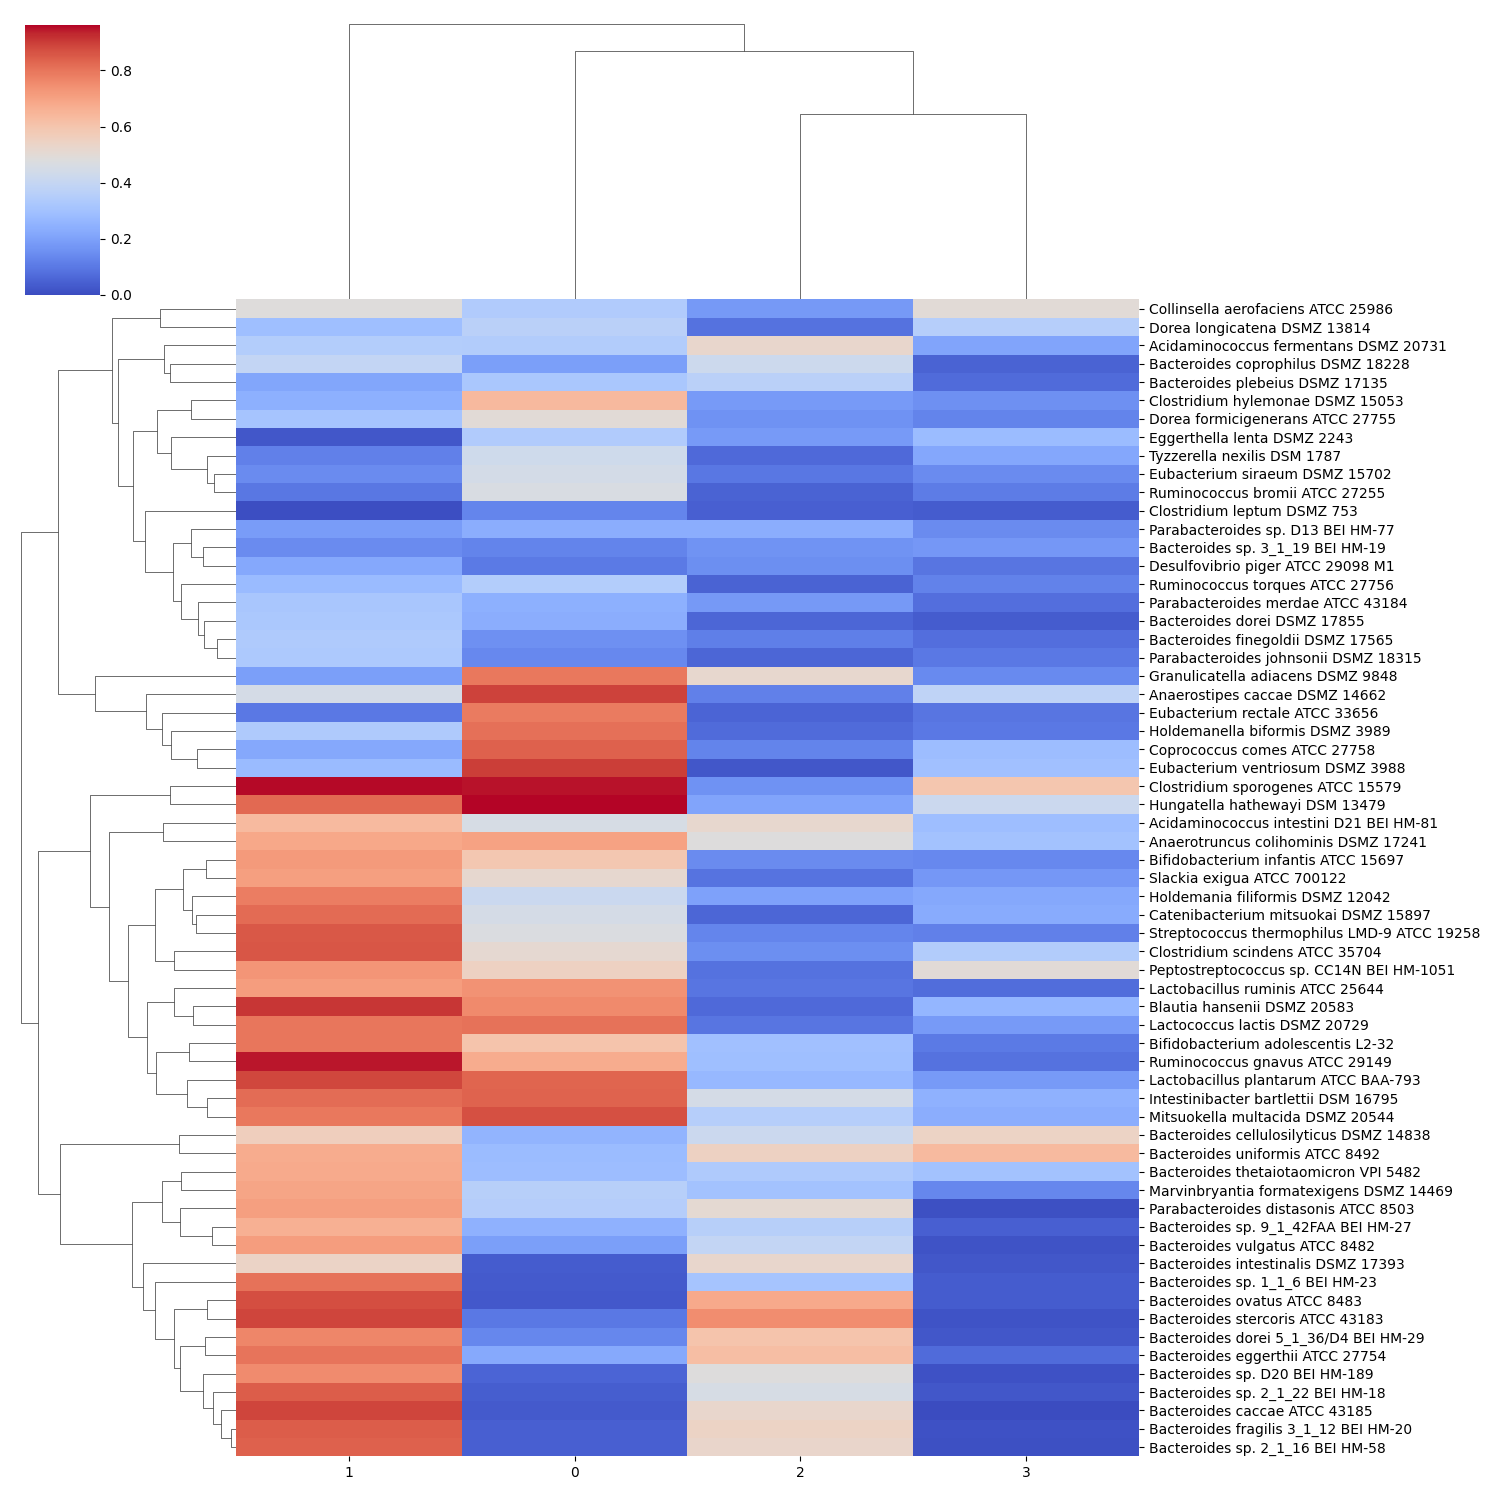

In [37]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(n_clusters)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [38]:
df_metabs_clusters.iloc[range(n_clusters), :]

cluster_labels  cluster_counts   
0               0              20  \
1               1              23   
2               2              54   
3               3              39   

                                   cluster_metab_IDs   
0  [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
1  [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2  [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
3  [1, 2, 6, 7, 9, 11, 17, 21, 24, 29, 32, 48, 49...   

                                  cluser_metab_names  
0  [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  
1  [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  
2  [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  
3  [NICOTINIC ACID, OLEIC ACID, 1-METHYL-HYDANTOI...

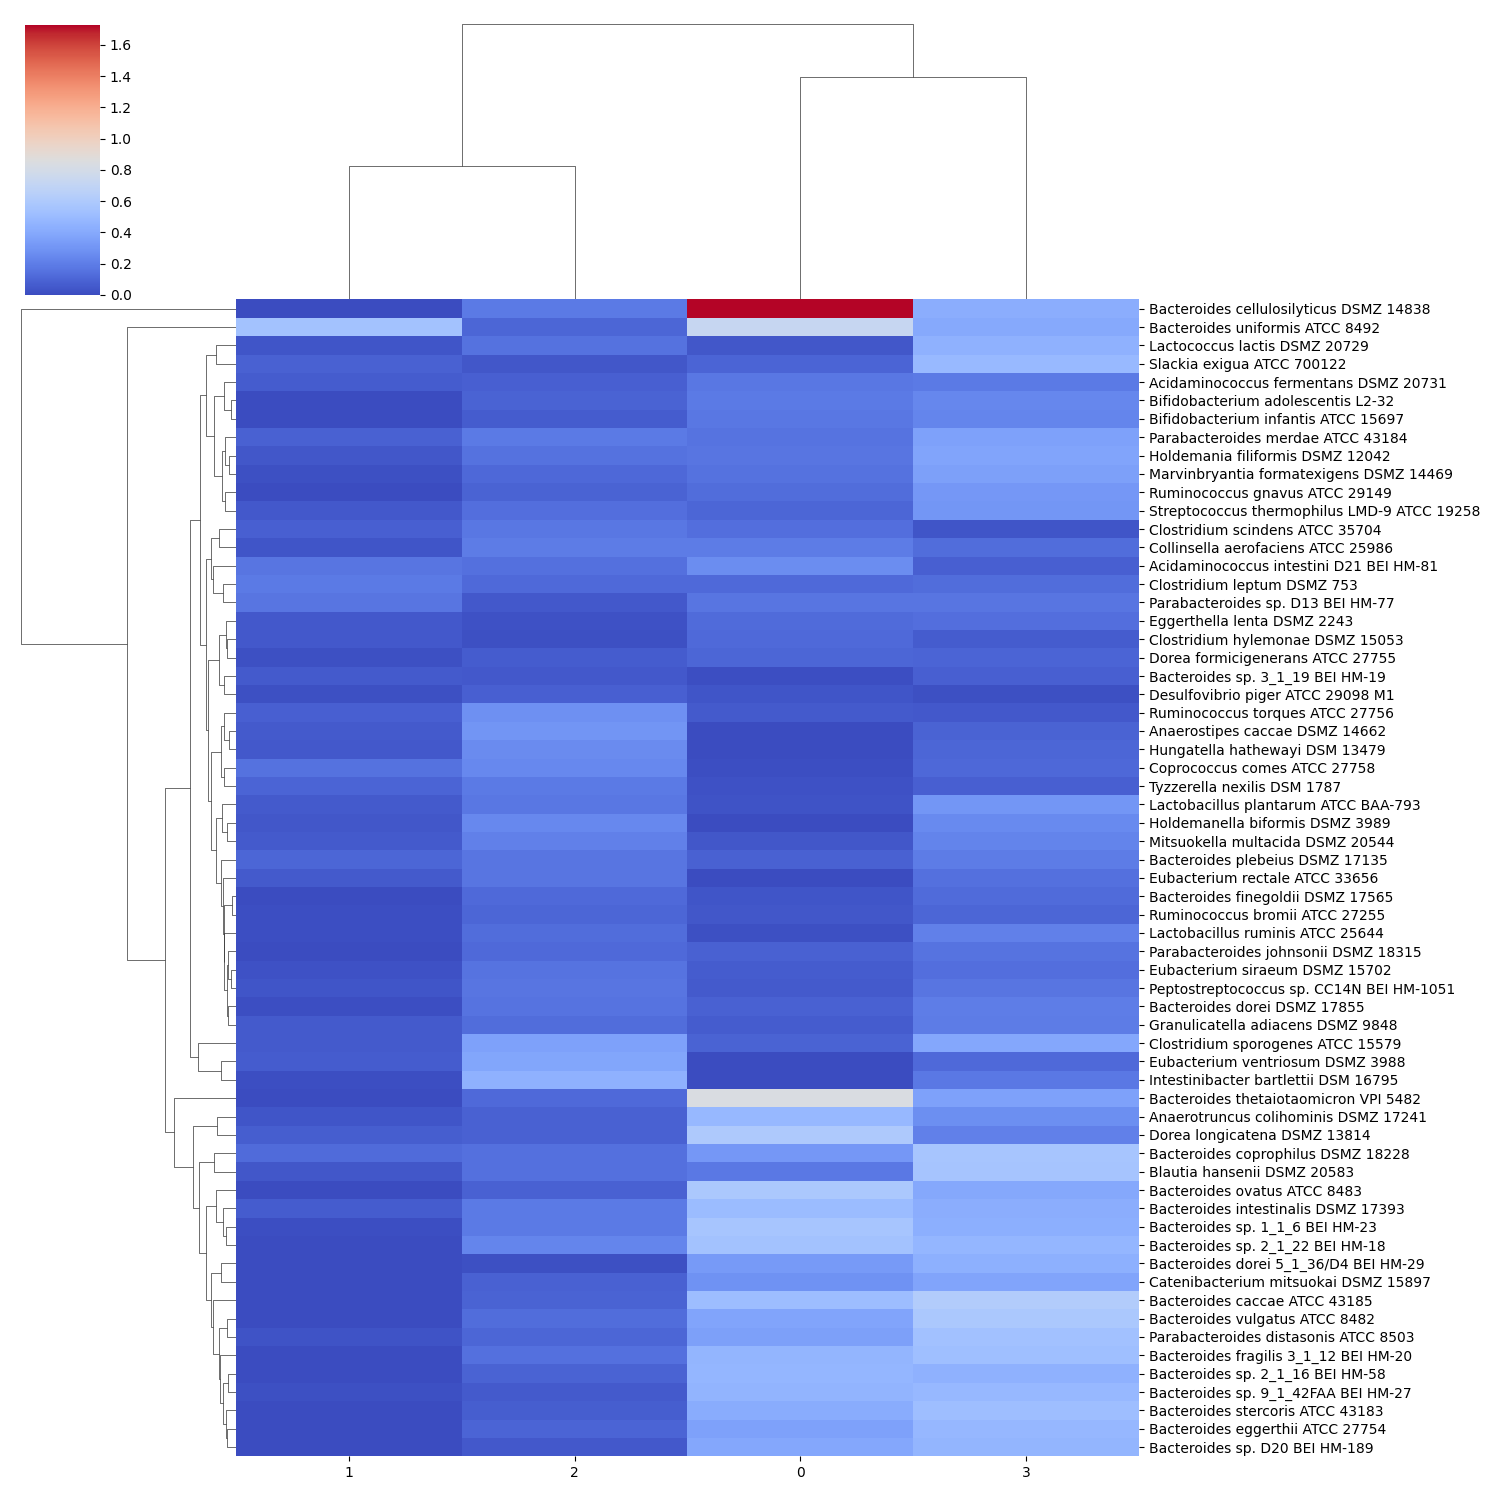

In [39]:
plt_ = sns.clustermap(df_speciesMetab_prod_cluster.iloc[:, range(n_clusters)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

# RMSE as a function of number of clusters

In [17]:
def fit_Ri_tmp(df_speciesMetab_cluster, df_speciesAbun_prev_mdl, \
               df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6):
    ## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
    date_ = '20230530'
    n_repeats = 10
    rand_seed = 7363
    np.random.seed(rand_seed)
    p_vec_new = [0.1]


    num_metabs_clust = df_speciesMetab_cluster.shape[1]
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    Ri_dynamic_obj = {}
    # Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
    #                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                 df_speciesAbun_ratio_mdl, p_vec_new, \
    #                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
    pass_keep = np.arange(num_passages - 1)
    id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
    pass_rm = [2, 3, 4]
    Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                    df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                    file_save="dummy", num_passages=5, pass_rm=pass_rm, num_brep=3, \
                                    save_data=False)
    # Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
    #                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                       df_speciesAbun_ratio_mdl, p_vec_new, \
    #                                       file_save, num_passages=5, pass_rm=[3, 4])
    # Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
    #                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                                       df_speciesAbun_ratio_mdl, \
    #                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
    # Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
    #                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
    #                        df_speciesAbun_ratio_mdl, \
    #                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

            
    Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
    Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
    Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']
    return Ri_noMicrocosm_dynamicAll_fit_joint

In [102]:
def get_RMSE(df_speciesMetab_cluster, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
             df_speciesAbun_ratio_mdl, Ri_noMicrocosm_dynamicAll_fit_joint, \
             df_speciesAbun_mdl_true=None, num_passages=6):
    num_metabs_clust = df_speciesMetab_cluster.shape[1]
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    p_vec_new = [0.1]
    count_p = 0

    RMSE_mat_full = np.zeros((num_passages - 1, 2))
    Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
    Ri_fit = {0: Ri_avg}
    # RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
    sens_obj_all, RMSE_obj_all = \
        blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                              df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                              df_speciesAbun_prev_mdl, \
                                              df_speciesAbun_ratio_mdl, \
                                              Ri_fit, "dummy", "dummy", \
                                              "dummy", num_passages=6, num_iter=100, \
                                              thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                              save_data_obj=False, \
                                              return_sensitivity_ana=True, \
                                              df_speciesAbun_mdl_true=df_speciesAbun_mdl_true)
    for pass_ in range(num_passages - 1):
        RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
        RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]
    return RMSE_mat_full

In [22]:
num_clusters = np.arange(1, 11)
RMSE_clusters = np.zeros((len(num_clusters), 2, 2))
p_vec_new = [0.1]
count_p = 0
for count_, nclust_ in enumerate(num_clusters):
    print(f'nclust = {nclust_}')
    df_metabs_clusters, df_speciesMetab_new = \
    get_metabs_clusters(df_speciesMetab.iloc[:, :].copy(), bin_thresh=0.3, species_num_thresh=5, \
                        n_clusters_hclust=nclust_, distance_metric="euclidean", \
                        method_cluster="ward")
    df_speciesMetab_cluster = avg_consumption_df(df_speciesMetab_new, df_metabs_clusters, \
                                                 metab_cluster_mean_func="linear")
    Ri_noMicrocosm_dynamicAll_fit_joint= \
        fit_Ri_tmp(df_speciesMetab_cluster, df_speciesAbun_prev_mdl, \
                   df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6)
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_cluster, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_noMicrocosm_dynamicAll_fit_joint, num_passages=6)
    print(f'p = {p_vec_new[count_p]}')
    RMSE_clusters[count_, :, :] = RMSE_mat_full[range(2), :].copy()
    

nclust = 1
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 2
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 3
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 4
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 5
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 6
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 7
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 8
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 9
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1
nclust = 10
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

p = 0.1


Text(0, 0.5, 'RMSE relative to #non-singleton clusters=10')

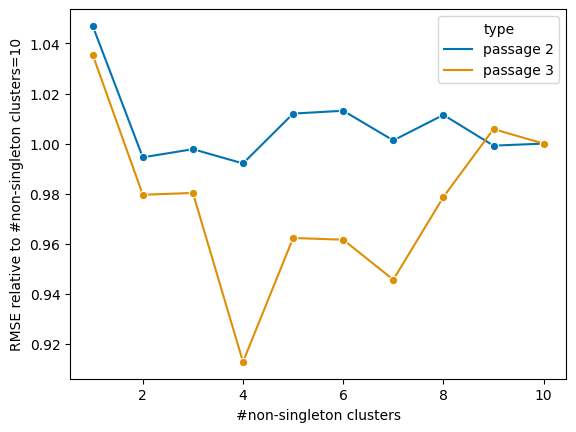

In [23]:
palette_ = sns.color_palette("colorblind", n_colors=2)
df_plt = pd.DataFrame(data={"x" : np.hstack([num_clusters, num_clusters]), \
                            "y" : (RMSE_clusters[:, :, 0] / RMSE_clusters[9, :, 0]).flatten(order='F'), \
                            "type" : ['passage 2'] * RMSE_clusters.shape[0] + \
                                ['passage 3'] * RMSE_clusters.shape[0]})
plt_ = sns.lineplot(data=df_plt, x="x", y="y", hue="type", palette=palette_, marker='o')
plt_.set_xlabel("#non-singleton clusters")
plt_.set_ylabel("RMSE relative to #non-singleton clusters=10")

## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs

In [10]:
nclusts = 10
df_metabs_clusters, df_speciesMetab_new, df_speciesMetab_prod_new = \
get_metabs_clusters(df_speciesMetab.copy(), df_speciesMetab_prod.copy(), \
                    bin_thresh=0.3, species_num_thresh=5, \
                    n_clusters_hclust=nclusts, distance_metric="euclidean", \
                    method_cluster="ward")
df_speciesMetab_cluster, df_speciesMetab_prod_cluster = \
    avg_consumption_df(df_speciesMetab_new, df_speciesMetab_prod_new, df_metabs_clusters, \
                       metab_cluster_mean_func="geometric")

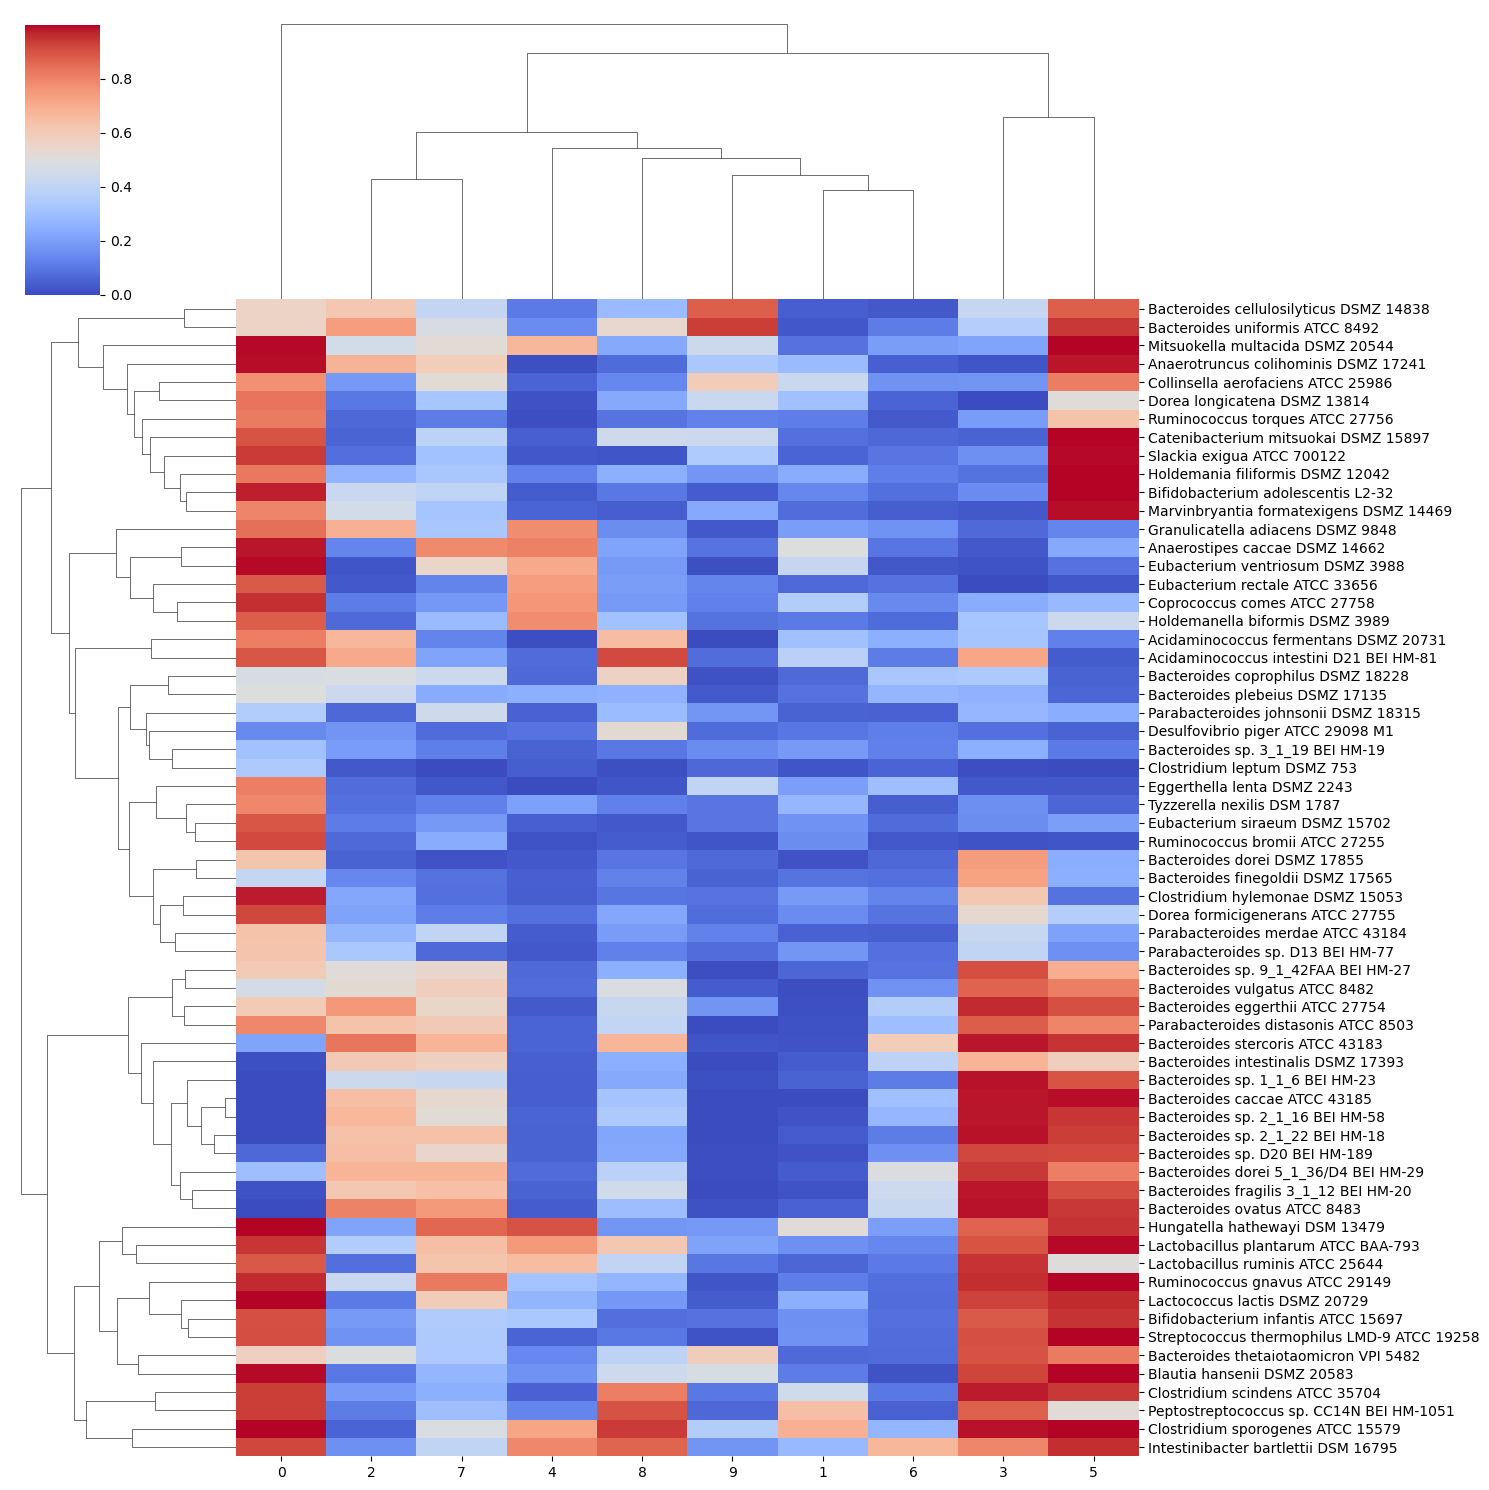

In [11]:
plt_ = sns.clustermap(df_speciesMetab_cluster.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

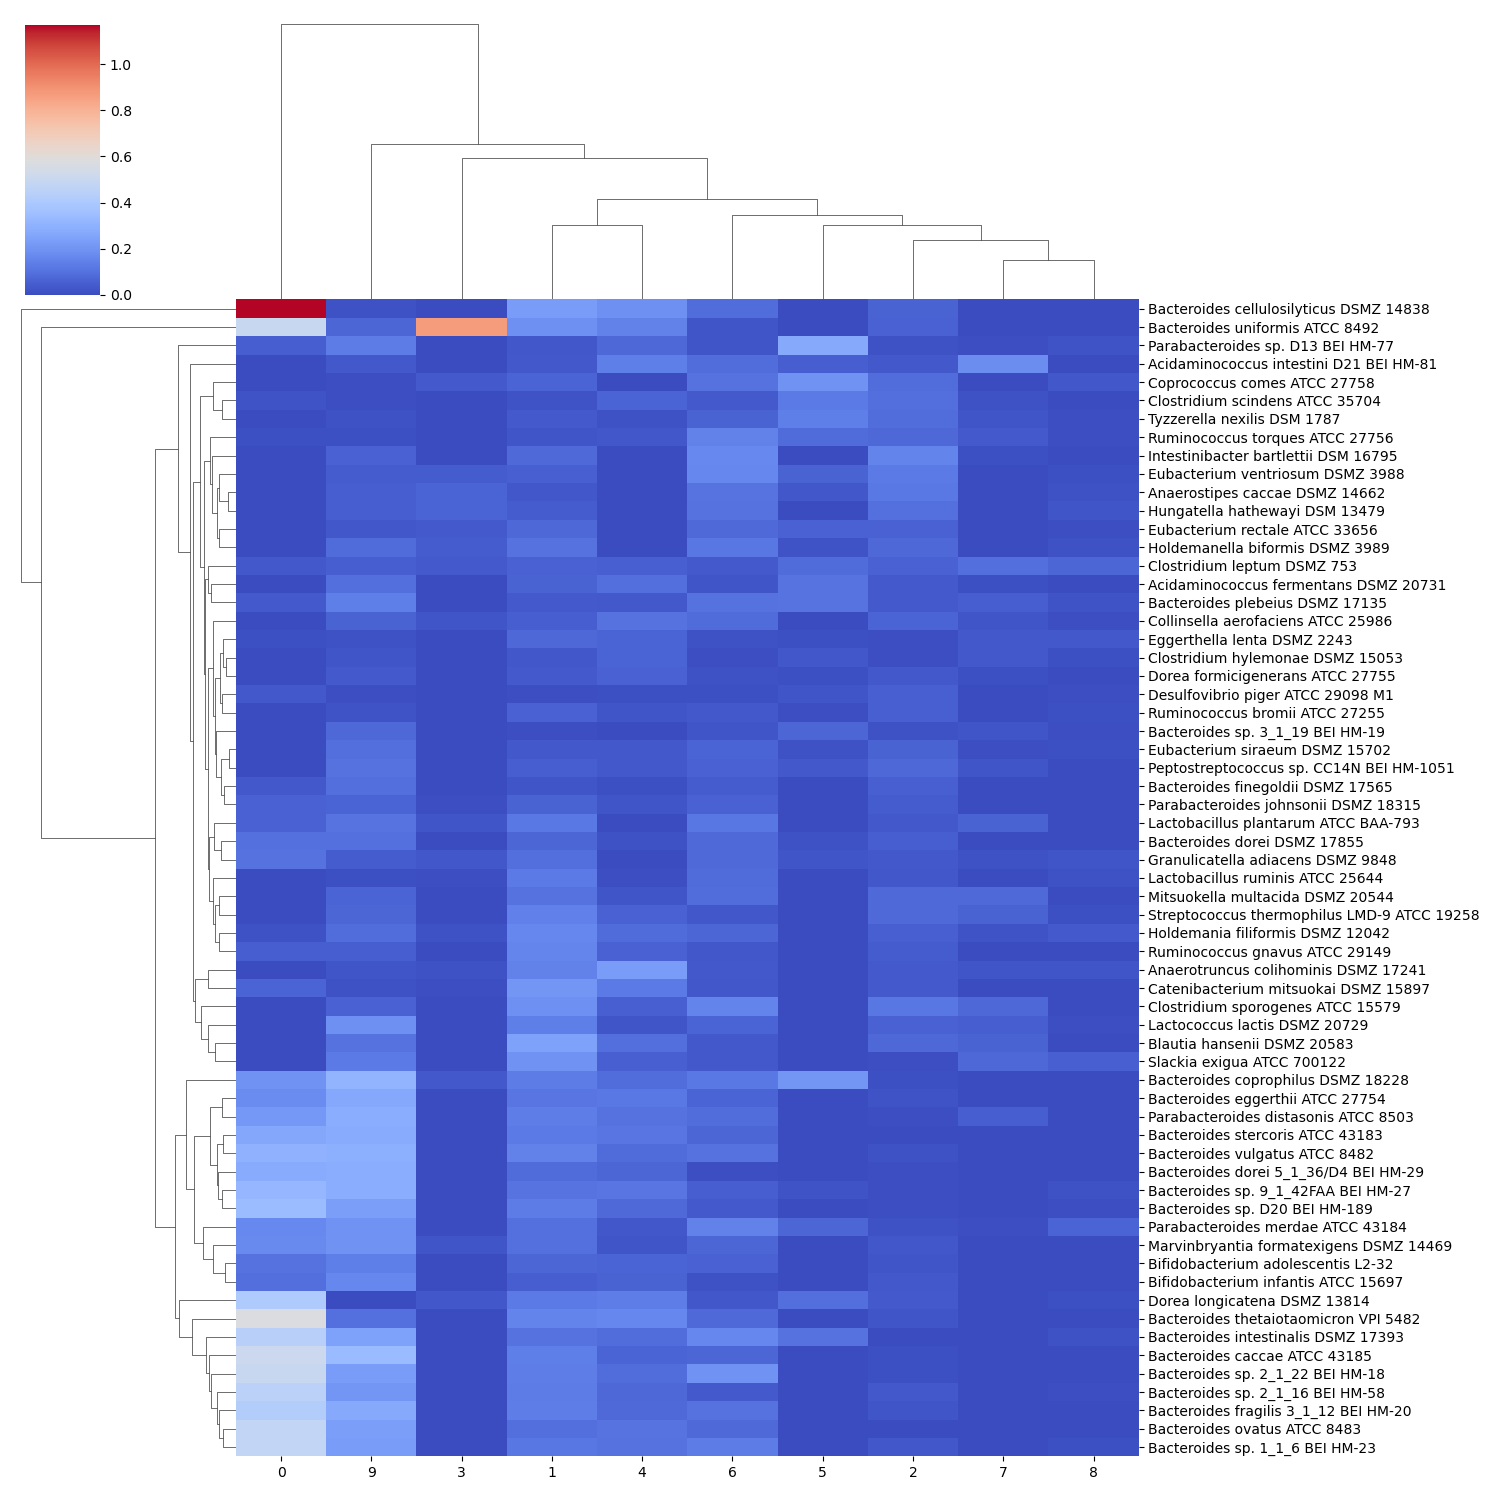

In [12]:
df_tmp = df_speciesMetab_prod_cluster.copy()
for col_ in df_tmp.columns.values:
    df_tmp[col_] = np.log10(1 + df_tmp[col_].values)
plt_ = sns.clustermap(df_tmp.iloc[:, range(nclusts)], \
                      cmap="coolwarm", figsize=(15, 15), \
                      metric=distance_metric, xticklabels=True, yticklabels=True)

In [14]:
df_metabs_clusters.iloc[range(nclusts), :]

cluster_labels  cluster_counts  \
0               0               5   
1               1              25   
2               2              30   
3               3               5   
4               4              15   
5               5               5   
6               6              24   
7               7               7   
8               8               6   
9               9              14   

                                   cluster_metab_IDs  \
0                            [70, 72, 114, 125, 134]   
1  [1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...   
2  [0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...   
3                              [35, 80, 93, 95, 106]   
4  [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...   
5                             [15, 73, 96, 100, 135]   
6  [10, 12, 14, 31, 33, 36, 42, 44, 50, 51, 52, 5...   
7                       [3, 27, 34, 39, 65, 99, 110]   
8                            [4, 8, 63, 79, 84, 126]   
9  [2, 9, 11, 17, 21, 29, 32, 49, 58, 60, 61, 75,...   

                                  cluser_metab_names  
0  [5'-METHYLTHIOADENOSINE, ADENINE, NICOTINAMIDE...  
1  [NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ...  
2  [N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI...  
3  [3-UREIDOPROPIONATE, ASPARAGINE, GLUTAMINE, GL...  
4  [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  
5  [1-METHYLADENOSINE, ADENOSINE, GUANOSINE, INOS...  
6  [CARNITINE, PHOSPHOCHOLINE, TRYPTOPHAN ETHYL E...  
7  [MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC...  
8  [THREONINE_0, CINNAMALDEHYDE, 1-AMINOCYCLOPROP...  
9  [OLEIC ACID, SPERMIDINE, AMINO(4-HYDROXYCYCLOH...

In [31]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230531'
# date_ = '20230607'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2_2to3'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [2, 3, 4]
Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                file_save, num_passages=5, pass_rm=pass_rm, num_brep=3)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 1, p_tmp = 0.01


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 2, p_tmp = 0.05


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 3, p_tmp = 0.06


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 4, p_tmp = 0.07


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 5, p_tmp = 0.08


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 6, p_tmp = 0.09


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 7, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 8, p_tmp = 0.125


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 9, p_tmp = 0.15


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 10, p_tmp = 0.175


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 11, p_tmp = 0.2


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 12, p_tmp = 0.3


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 13, p_tmp = 0.4


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 14, p_tmp = 0.5


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Tar

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Tar

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in sqrt
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/Ta

count = 15, p_tmp = 0.55


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 16, p_tmp = 0.6


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 17, p_tmp = 0.65


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

count = 18, p_tmp = 0.7


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

In [25]:
date_ = '20230531'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2_2to3'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [81]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True)
for pass_ in range(num_passages):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [82]:
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(2, 3, figsize=(40, 35), sharey="row", sharex=None)
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(4):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_meeting'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_passage1to2_2to3_predict_with_inoc.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0


/tmp/ipykernel_29002/1356976234.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_29002/1356976234.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 1


/tmp/ipykernel_29002/1356976234.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 2


/tmp/ipykernel_29002/1356976234.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 1, col = 0


/tmp/ipykernel_29002/1356976234.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_29002/1356976234.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


In [46]:
x

array([ -5.78841631,  -5.78841631,  -5.78841631,  -0.51583105,
        -0.51583105,  -0.51583105,  -1.04974713,  -1.04974713,
        -1.04974713, -10.35074791, -10.35074791, -10.35074791,
        -9.27530312,  -9.27530312,  -9.27530312,  -8.8032845 ,
        -8.8032845 ,  -8.8032845 ,  -7.90507091,  -7.90507091,
        -7.90507091,  -4.66590956,  -4.66590956,  -4.66590956,
        -4.08703965,  -4.08703965,  -4.08703965,  -1.71671271,
        -1.71671271,  -1.71671271,  -4.24138785,  -4.24138785,
        -4.24138785,  -2.43203607,  -2.43203607,  -2.43203607,
        -5.33692004,  -5.33692004,  -5.33692004,  -2.91147751,
        -2.91147751,  -2.91147751,  -5.60000549,  -5.60000549,
        -5.60000549,  -4.44519922,  -4.44519922,  -4.44519922,
        -3.78044807,  -3.78044807,  -3.78044807,  -2.36263515,
        -2.36263515,  -2.36263515,  -2.41644594,  -2.41644594,
        -2.41644594,  -2.12541513,  -2.12541513,  -2.12541513,
        -6.81864531,  -6.81864531,  -6.81864531,  -0.87

In [26]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.iloc[:, :].copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
df_metabs_clusters_order.iloc[range(20), :]

cluster_labels  cluster_counts   
0                0              20  \
86              86               1   
1                1              23   
2                2              54   
74              74               1   
31              31               1   
39              39               1   
84              84               1   
18              18               1   
25              25               1   
3                3              39   
4                4               1   
17              17               1   
60              60               1   
58              58               1   
47              47               1   
76              76               1   
20              20               1   
64              64               1   
85              85               1   

                                    cluster_metab_IDs   
0   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
86                                              [218]   
1   [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2   [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
74                                              [206]   
31                                              [163]   
39                                              [171]   
84                                              [216]   
18                                              [150]   
25                                              [157]   
3   [1, 2, 6, 7, 9, 11, 17, 21, 24, 29, 32, 48, 49...   
4                                               [136]   
17                                              [149]   
60                                              [192]   
58                                              [190]   
47                                              [179]   
76                                              [208]   
20                                              [152]   
64                                              [196]   
85                                              [217]   

                                   cluser_metab_names        Ri  
0   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.163128  
86                                [PYROGLUTAMIC ACID]  0.148750  
1   [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  0.113981  
2   [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  0.057813  
74                               [N-ACETYLTRYPTOPHAN]  0.025076  
31                                     [BETA-LACTOSE]  0.024891  
39                                    [ACETYLCHOLINE]  0.024263  
84                                       [PYRIDOXINE]  0.024075  
18                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.023086  
25                                    [3-FUROIC ACID]  0.022004  
3   [NICOTINIC ACID, OLEIC ACID, 1-METHYL-HYDANTOI...  0.021367  
4                                     [GALACTOSAMINE]  0.016310  
17                        [IS_METHIONINE-METHYL-D3_0]  0.014926  
60                                         [CYTOSINE]  0.013678  
58                                       [CREATININE]  0.012152  
47                                           [3'-CMP]  0.011728  
76                                 [N-BUTYRYLGLYCINE]  0.009623  
20           [IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID_0]  0.009366  
64                                        [HISTAMINE]  0.008878  
85                                       [PYROGALLOL]  0.008036

In [36]:
df_metabs_clusters_order.iloc[range(20), 3].values

array([list(['BETA-ALANINE_0', 'OMEGA-HYDROXYDODECANOIC ACID', 'IS_PHENYLALANINE-2,3,4,5,6-D5_0', 'IS_D15-OCTANOIC ACID_0', 'IS_D19-DECANOIC ACID_0', 'IS_TRIDECANOIC ACID_0', 'IS_D27-TETRADECANOIC ACID_0', 'XANTHINE', '4-ACETAMIDOPHENOL', '3-HYDROXYPHENYLACETIC ACID', "5'-METHYLTHIOADENOSINE", 'ADENINE', 'CADAVERINE', 'CHOLINE', 'LUMICHROME', 'NICOTINAMIDE', 'PYRIDOXAMINE', "S-(5'-ADENOSYL)-L-HOMOCYSTEINE", 'SUBERIC ACID', 'URACIL']),
       list(['PYROGLUTAMIC ACID']),
       list(['MANNOSE 6-PHOSPHATE', 'THREONINE_0', 'CINNAMALDEHYDE', '1-METHYLADENOSINE', 'GLUCOSE', 'SUCROSE_1', '3-UREIDOPROPIONATE', 'GLYCERIC ACID', '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', '1,6-ANHYDRO-B-GLUCOSE', 'ADENOSINE', 'ASP-PHE', 'ASPARAGINE', 'CARNOSINE', 'GLUTAMINE', 'GLYCYL-GLYCINE', 'GUANOSINE', 'HYPOXANTHINE', 'INOSINE', 'METHYLMALONIC ACID_1', 'N-ACETYLNEURAMINATE', 'SERINE', 'URIDINE']),
       list(['N-METHYL-ASPARTIC ACID_0', 'CARNITINE', 'PHOSPHOCHOLINE', 'TRYPTOPHAN ETHYL ESTER', 'STEARIC ACID', 

## blind predict abundance

In [78]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                          df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                          df_speciesAbun_prev_mdl, \
                                          df_speciesAbun_ratio_mdl, \
                                          Ri_fit, "dummy", "dummy", \
                                          "dummy", num_passages=6, num_iter=100, \
                                          thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                          save_data_obj=False, \
                                          return_sensitivity_ana=True)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [79]:
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(1, 3, figsize=(40, 20), sharey="row", sharex="col")
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[pass_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[pass_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 2}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[pass_].set_title(title_, size=30)
    if ax_row_ == 1:
        plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_meeting'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_passage1to2_2to3_predict_without_inoc.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0


/tmp/ipykernel_29002/1073823616.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_29002/1073823616.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 1


/tmp/ipykernel_29002/1073823616.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 2


/tmp/ipykernel_29002/1073823616.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


## blind predict growth ratio

row = 0, col = 0


/tmp/ipykernel_7762/2460390363.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 0, col = 1
row = 0, col = 2
row = 1, col = 0


/tmp/ipykernel_7762/2460390363.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_7762/2460390363.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)


row = 1, col = 1


/tmp/ipykernel_7762/2460390363.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


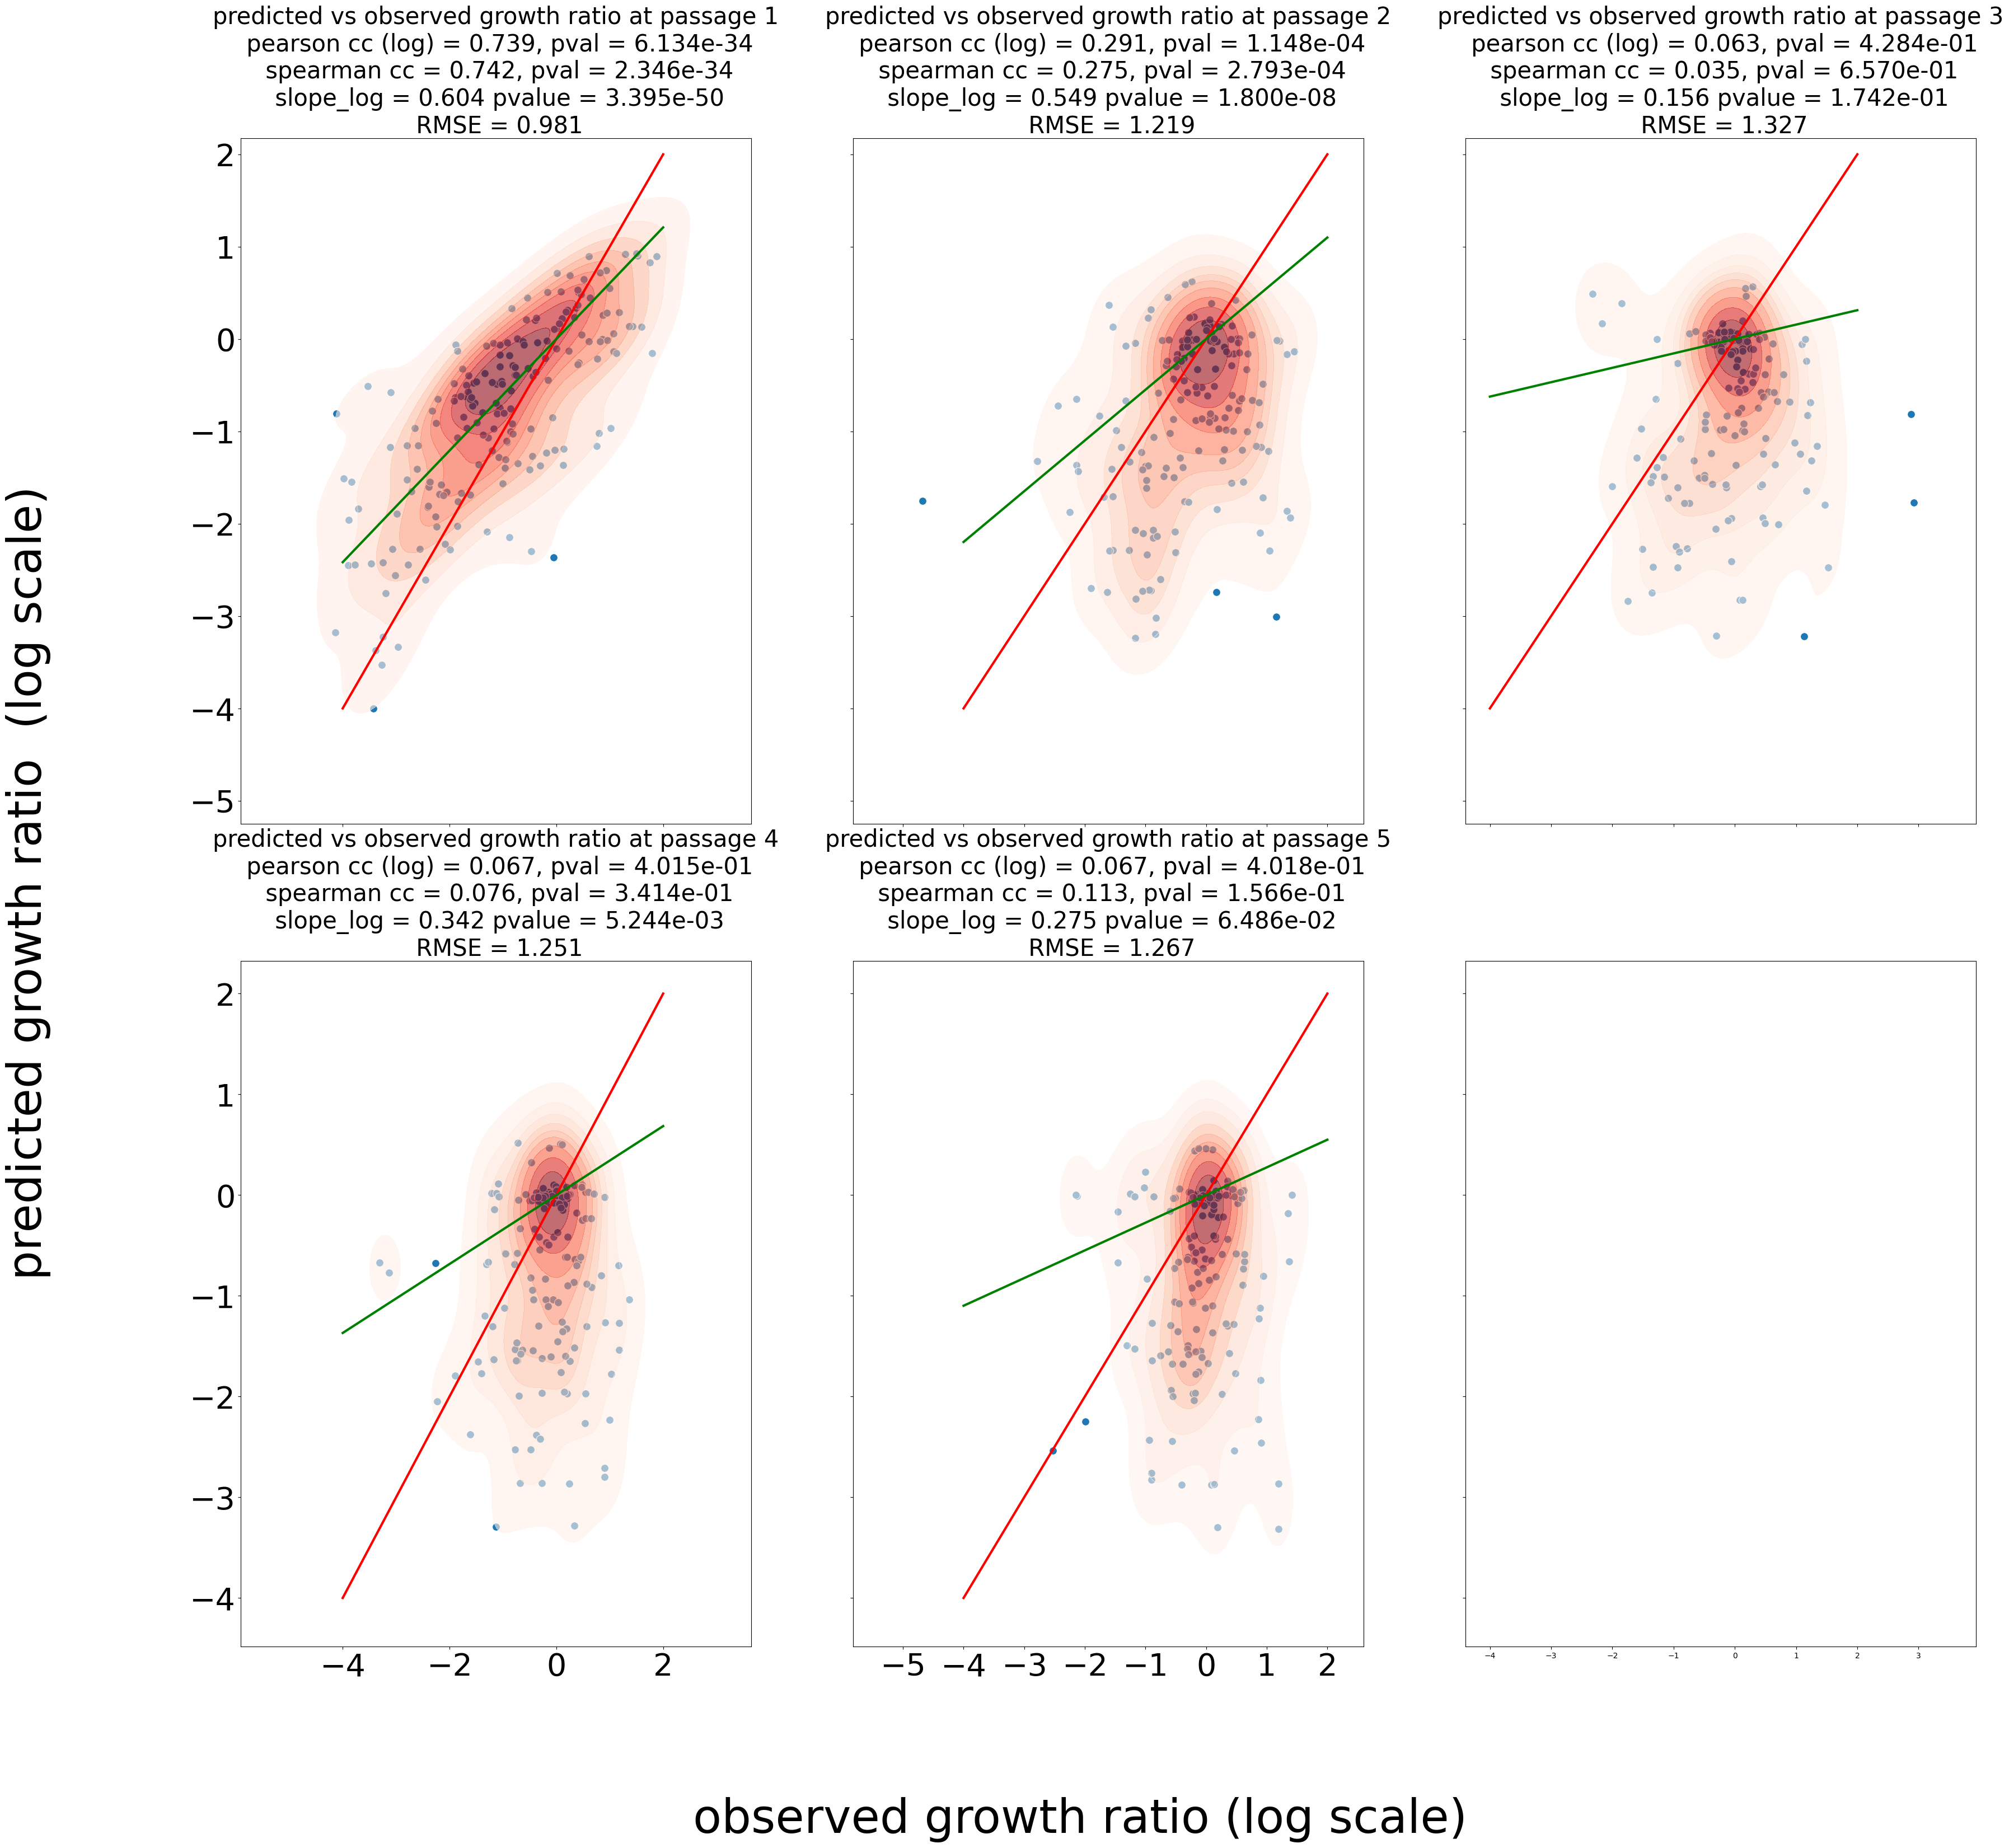

In [38]:
num_iter = 100
fig, axes = plt.subplots(2, int(num_passages / 2), \
                             figsize=(40, 35), sharey="row", sharex="col")
fig.supylabel('predicted growth ratio  (log scale)', fontsize=60)
fig.supxlabel('observed growth ratio (log scale)', fontsize=60)
for pass_ in range(num_passages - 1):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')


    if pass_ <= 10:
        growth_rate_all = sens_obj_all[pass_]['growth_rate_all']
        df_speciesAbun_prev_tmp_ = sens_obj_all[pass_]['df_speciesAbun_prev']
        df_tmp = pd.DataFrame()
        for col_ in df_speciesAbun_prev_tmp_.columns.values:
            df_tmp[col_] = \
                growth_rate_all.copy()[col_].values * \
                df_speciesAbun_prev_tmp_[col_].values
            df_tmp[col_] /= np.sum(df_tmp[col_].values)
#         df_tmp = df_speciesAbun_next_mdl.iloc[:, [pass_, \
#                                                     pass_ + (num_passages - 1), \
#                                                     pass_ + 2 * (num_passages - 1)]].copy()

    b_ = range(3)
#     x = \
#         np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_ + 1, \
#                                                     pass_ + 1 + num_passages, \
#                                                     pass_ + 1 + 2 * num_passages]])
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    
    x = \
        np.array(df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, \
                                                    pass_ + num_passages - 1, \
                                                    pass_ + 2 * (num_passages - 1)]])
    x = x.flatten()
#     y = np.array(df_tmp.copy())[:, :].flatten()
    y = np.array(growth_rate_all.copy()).flatten()
    thresh_zero = 1e-4
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -4] = -4

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-4, 2], [-4, 2], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -4) & (y <= -4))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed growth ratio at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
    if ax_row_ == 1:
        plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)

# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                         'predictions', 'leaveOneOut', \
#                                         f'{date_}_for_paper_compare_greedy_rm_metabs' + \
#                                         f'_predict_abundance_blind_growth_ratio' + \
#                                         f'_Ri_fit_dynamic' + \
#                                         f'_nocluster_metabolites_new_hierachClust_{microcosm_type}' + \
#                                         f'_pass_1to2_2to3_notremove_metabs_greedy_pareto_clusteredMetabs'))
# if not os.path.exists(save_dir):
#    # Create a new directory because it does not exist
#    os.makedirs(save_dir)

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_growth_' + \
#                                             f'consolidated' + \
#                                             f'_with_p{p_vec_new[count_p]}_dynamics_till_passage3_' + \
#                                             f'clusterMetabs.png'))

# fig.figure.savefig(file_save, \
#                     dpi=300, transparent=False, facecolor="white")
# plt.close(fig.figure)

# Find keystone metabolite clusters

In [61]:
count_p = 7
Ri_complete = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [40]:
num_metabs = df_speciesMetab_cluster.shape[1]
RMSE_metabs_clust_rm = np.zeros((num_metabs, 2, 2))

for m_ in range(num_metabs):
    print(f'loop = {m_}')
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    id_keep = list(set(list(range(num_metabs))) - set([m_]))
    df_speciesMetab_tmp = df_speciesMetab_tmp.iloc[:, id_keep]
    Ri_tmp = \
        fit_Ri_tmp(df_speciesMetab_tmp, df_speciesAbun_prev_mdl, \
                   df_speciesAbun_next_mdl, df_speciesAbun_ratio_mdl, num_passages=6)
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_tmp, df_speciesAbun_mdl, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_tmp, num_passages=6)
    RMSE_metabs_clust_rm[m_, :, :] = RMSE_mat_full[range(2), :].copy() 

loop = 0
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 1
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 2
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 3
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 4
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 5
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 6
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 7
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 8
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 9
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 10
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 11
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 12
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 13
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 14
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 15
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 16
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 17
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 18
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 19
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 20
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 21
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 22
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 23
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 24
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 25
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 26
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 27
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 28
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 29
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 30
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 31
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 32
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 33
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 34
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 35
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 36
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 37
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 38
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 39
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 40
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 41
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 42
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 43
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 44
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 45
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 46
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 47
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 48
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 49
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 50
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 51
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 52
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 53
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 54
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 55
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 56
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 57
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 58
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 59
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 60
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 61
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 62
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 63
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 64
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 65
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 66
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 67
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 68
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 69
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 70
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 71
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 72
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 73
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 74
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 75
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 76
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 77
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 78
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 79
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 80
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 81
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 82
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 83
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 84
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 85
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 86
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 87
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 88
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 89
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 90
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

loop = 91
count = 0, p_tmp = 0.1


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:441: RuntimeWarning: invalid value encountered in power
  tmp_ratio = tmp_ratio**(p_tmp_new)
/media/atheistpo

In [44]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_comp = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                          df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                          df_speciesAbun_prev_mdl, \
                                          df_speciesAbun_ratio_mdl, \
                                          Ri_fit, "dummy", "dummy", \
                                          "dummy", num_passages=6, num_iter=100, \
                                          thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                          save_data_obj=False, \
                                          return_sensitivity_ana=True)
for pass_ in range(num_passages - 1):
    RMSE_mat_comp[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_comp[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [45]:
RMSE_mat_comp

array([[1.00308866, 0.98063032],
       [1.24386658, 1.21869474],
       [1.66754409, 1.32746838],
       [1.93984124, 1.25066903],
       [2.18161873, 1.26708284]])

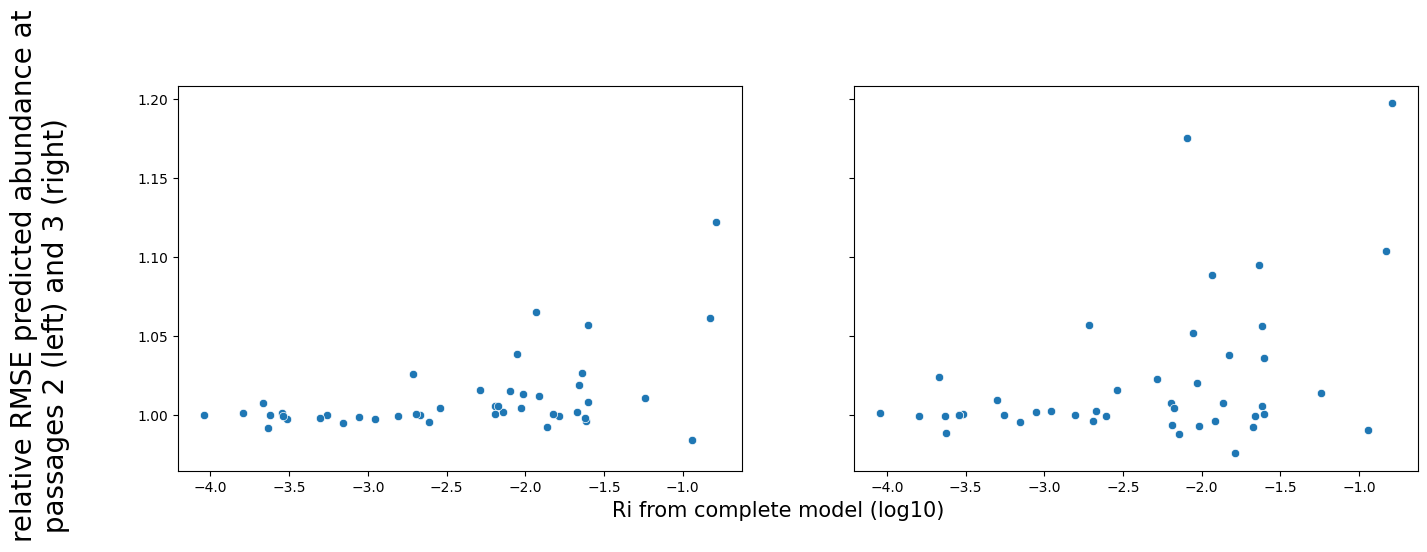

In [85]:
vals_ = RMSE_metabs_clust_rm[:, :, 0].copy() / RMSE_mat_comp[np.range(2), 0].copy()
x = vals_[:, 0]
y = vals_[:, 1]
z = Ri_complete.copy()
z[z == 0] = 1e-7
z = np.log10(z)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey="row", sharex="col")
fig.supylabel(f'relative RMSE predicted abundance at\n passages 2 (left) and 3 (right)', fontsize=20)
fig.supxlabel('Ri from complete model (log10)', fontsize=15)
id_ = np.where((z <= -7))[0]
id_keep = list(set(list(range(num_metabs))) - set(list(id_)))
plt_ = sns.scatterplot(x=z[id_keep], y=x[id_keep], ax=axes[0])
plt_ = sns.scatterplot(x=z[id_keep], y=y[id_keep], ax=axes[1])

In [101]:
id_y = np.where(y >= 1.075)[0]
print(Ri_complete[id_y])
# print(Ri_complete[id_y])
df_metabs_clusters.iloc[id_y[[1, 2, 3]], :]

[0.16312813 0.0230857  0.01172822 0.00803561 0.14874984]


cluster_labels  cluster_counts cluster_metab_IDs   
18              18               1             [150]  \
47              47               1             [179]   
85              85               1             [217]   

                   cluser_metab_names  
18  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  
47                           [3'-CMP]  
85                       [PYROGALLOL]

In [99]:
id_x = np.where(x >= 1.05)[0]
print(Ri_complete[id_x[[1, 2]]])
df_metabs_clusters.iloc[id_x[[1, 2]], :]

[0.01172822 0.0250763 ]


cluster_labels  cluster_counts cluster_metab_IDs    cluser_metab_names
47              47               1             [179]              [3'-CMP]
74              74               1             [206]  [N-ACETYLTRYPTOPHAN]

## keystone species

In [109]:
num_metabs = df_speciesMetab_cluster.shape[1]
RMSE_species_rm = np.zeros((num_species, 2, 2))
Ri_tmp = Ri_complete.copy()
Ri_fit = {0 : Ri_tmp}

for m_ in range(num_species):
    print(f'loop = {m_}')
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    df_speciesAbun_mdl_tmp = df_speciesAbun_mdl.copy()
    df_speciesAbun_mdl_tmp.iloc[m_, :] = 0
    RMSE_mat_full= \
        get_RMSE(df_speciesMetab_tmp, df_speciesAbun_mdl_tmp, df_speciesAbun_prev_mdl, \
                 df_speciesAbun_ratio_mdl, Ri_fit, num_passages=6, \
                 df_speciesAbun_mdl_true=df_speciesAbun_mdl.copy())
    RMSE_species_rm[m_, :, :] = RMSE_mat_full[range(2), :].copy() 

loop = 0
loop = 1
loop = 2
loop = 3
loop = 4
loop = 5
loop = 6
loop = 7
loop = 8
loop = 9
loop = 10
loop = 11
loop = 12
loop = 13
loop = 14
loop = 15
loop = 16
loop = 17
loop = 18
loop = 19
loop = 20
loop = 21
loop = 22
loop = 23
loop = 24
loop = 25
loop = 26
loop = 27
loop = 28
loop = 29
loop = 30
loop = 31
loop = 32
loop = 33
loop = 34
loop = 35


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: divide by zero encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: invalid value encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = 

loop = 36
loop = 37
loop = 38
loop = 39
loop = 40
loop = 41
loop = 42
loop = 43
loop = 44
loop = 45
loop = 46
loop = 47
loop = 48
loop = 49
loop = 50
loop = 51


/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: divide by zero encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:138: RuntimeWarning: invalid value encountered in divide
  mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
/media/atheistpoet/TarunHDD/maslov_lab/crn_gut_microbiome/src/utils.py:671: RuntimeWarning: invalid value encountered in matmul
  vals_tmp = 

loop = 52
loop = 53
loop = 54
loop = 55
loop = 56
loop = 57
loop = 58
loop = 59
loop = 60
loop = 61
loop = 62


ValueError: All arrays must be of the same length

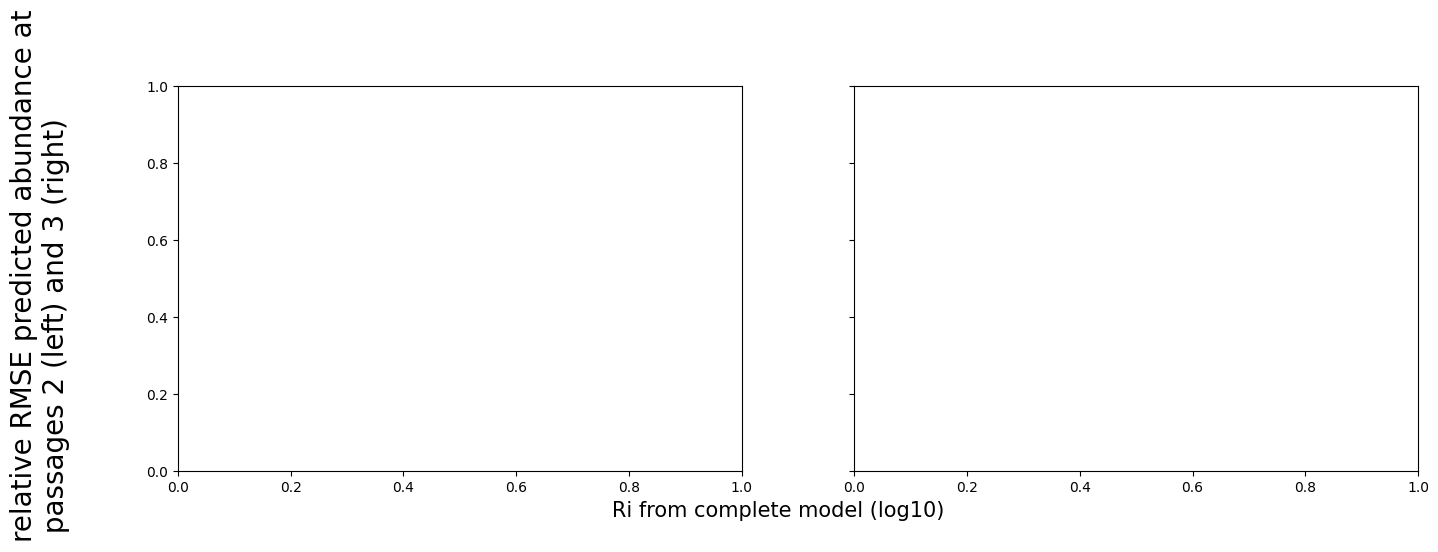

In [113]:
vals_ = RMSE_species_rm[:, :, 0].copy() / RMSE_mat_comp[range(2), 0].copy()
x = vals_[:, 0]
y = vals_[:, 1]
pass_ = [2, 2 + 6, 2 + 12]
z = np.array(df_speciesAbun_mdl.iloc[:, pass_])
z = np.mean(np.log10(z), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey="row", sharex="col")
fig.supylabel(f'relative RMSE predicted abundance at\n passages 2 (left) and 3 (right)', fontsize=20)
fig.supxlabel('Ri from complete model (log10)', fontsize=15)
plt_ = sns.scatterplot(x=z, y=x, ax=axes[0])
plt_ = sns.scatterplot(x=z, y=y, ax=axes[1])

## fit dynamic Ri for passage transition 1->2 for clustered metabs

In [38]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230605'
date_ = '20230607'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [1, 2, 3, 4]
Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                file_save, num_passages=5, pass_rm=pass_rm, num_brep=3)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001
count = 1, p_tmp = 0.01
count = 2, p_tmp = 0.05
count = 3, p_tmp = 0.06
count = 4, p_tmp = 0.07
count = 5, p_tmp = 0.08
count = 6, p_tmp = 0.09
count = 7, p_tmp = 0.1
count = 8, p_tmp = 0.125
count = 9, p_tmp = 0.15
count = 10, p_tmp = 0.175
count = 11, p_tmp = 0.2
count = 12, p_tmp = 0.3
count = 13, p_tmp = 0.4
count = 14, p_tmp = 0.5
count = 15, p_tmp = 0.55
count = 16, p_tmp = 0.6
count = 17, p_tmp = 0.65
count = 18, p_tmp = 0.7


In [14]:
date_ = '20230605'
date_ = '20230607'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_for_paper_compare_greedy_rm_metabs' + \
                                        f'_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [15]:
count_p = 7
Ri_use_B_alone = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [33]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True)
for pass_ in range(num_passages):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [17]:
RMSE_mat_full

array([[1.52878178, 1.50893284],
       [1.67404776, 0.96118451],
       [1.97452181, 1.43229129],
       [2.09916744, 1.64168793],
       [2.31063772, 1.58131467],
       [2.52968953, 1.56198557]])

In [102]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.iloc[:, :].copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
df_metabs_clusters_order.iloc[range(20), :]

cluster_labels  cluster_counts   
0                0              20  \
86              86               1   
31              31               1   
47              47               1   
1                1              23   
2                2              54   
9                9               1   
32              32               1   
18              18               1   
13              13               1   
74              74               1   
76              76               1   
84              84               1   
60              60               1   
4                4               1   
25              25               1   
30              30               1   
58              58               1   
64              64               1   
17              17               1   

                                    cluster_metab_IDs   
0   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 70, 72...  \
86                                              [218]   
31                                              [163]   
47                                              [179]   
1   [3, 4, 8, 15, 27, 34, 35, 39, 63, 65, 73, 79, ...   
2   [0, 10, 12, 14, 16, 25, 26, 28, 30, 31, 33, 36...   
9                                               [141]   
32                                              [164]   
18                                              [150]   
13                                              [145]   
74                                              [206]   
76                                              [208]   
84                                              [216]   
60                                              [192]   
4                                               [136]   
25                                              [157]   
30                                              [162]   
58                                              [190]   
64                                              [196]   
17                                              [149]   

                                   cluser_metab_names        Ri  
0   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.211311  
86                                [PYROGLUTAMIC ACID]  0.151586  
31                                     [BETA-LACTOSE]  0.057809  
47                                           [3'-CMP]  0.050739  
1   [MANNOSE 6-PHOSPHATE, THREONINE_0, CINNAMALDEH...  0.044122  
2   [N-METHYL-ASPARTIC ACID_0, CARNITINE, PHOSPHOC...  0.041869  
9                    [2-HYDROXY-2-METHYLBUTYRIC ACID]  0.024568  
32                            [IS_LEUCINE-5,5,5-D3_1]  0.023686  
18                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.021505  
13                                          [CYSTINE]  0.021032  
74                               [N-ACETYLTRYPTOPHAN]  0.017201  
76                                 [N-BUTYRYLGLYCINE]  0.015581  
84                                       [PYRIDOXINE]  0.015269  
60                                         [CYTOSINE]  0.014986  
4                                     [GALACTOSAMINE]  0.013626  
25                                    [3-FUROIC ACID]  0.013517  
30                                    [DECANOIC ACID]  0.012072  
58                                       [CREATININE]  0.011915  
64                                        [HISTAMINE]  0.011689  
17                        [IS_METHIONINE-METHYL-D3_0]  0.011069

In [27]:
x

array([ -5.17282501,  -5.17282501,  -5.17282501,  -0.64144363,
        -0.64144363,  -0.64144363,  -1.60178924,  -1.60178924,
        -1.60178924, -12.53127144, -12.53127144, -12.53127144,
       -10.70969395, -10.70969395, -10.70969395,  -9.61078327,
        -9.61078327,  -9.61078327,  -7.93213024,  -7.93213024,
        -7.93213024,  -5.72030393,  -5.72030393,  -5.72030393,
        -3.12336294,  -3.12336294,  -3.12336294,  -2.17566084,
        -2.17566084,  -2.17566084,  -5.78544342,  -5.78544342,
        -5.78544342,  -2.32819085,  -2.32819085,  -2.32819085,
        -4.48867072,  -4.48867072,  -4.48867072,  -2.47073791,
        -2.47073791,  -2.47073791,  -5.43724247,  -5.43724247,
        -5.43724247,  -5.21232316,  -5.21232316,  -5.21232316,
        -4.61916777,  -4.61916777,  -4.61916777,  -1.61637849,
        -1.61637849,  -1.61637849,  -3.07411473,  -3.07411473,
        -3.07411473,  -2.24503391,  -2.24503391,  -2.24503391,
        -8.33011498,  -8.33011498,  -8.33011498,  -1.91

In [34]:
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(2, 3, figsize=(40, 35), sharey="row", sharex=None)
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(4):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_meeting'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

# file_save = os.path.abspath(os.path.join(save_dir, 
#                                             f'predicted_vs_observed_abundance_' + \
#                                             f'Ri_fit_passage1to2_predict_with_inoc.png'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_{nclusts}clusters_passage1to2_predict_with_inoc.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0


/tmp/ipykernel_8342/3672422980.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_8342/3672422980.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 1


/tmp/ipykernel_8342/3672422980.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 2


/tmp/ipykernel_8342/3672422980.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 1, col = 0


/tmp/ipykernel_8342/3672422980.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_8342/3672422980.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


# without inoc

In [68]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages - 1, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth_without_inoc([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                          df_speciesAbun_inoc, df_speciesAbun_mdl, \
                                          df_speciesAbun_prev_mdl, \
                                          df_speciesAbun_ratio_mdl, \
                                          Ri_fit, "dummy", "dummy", \
                                          "dummy", num_passages=6, num_iter=100, \
                                          thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                          save_data_obj=False, \
                                          return_sensitivity_ana=True)
for pass_ in range(num_passages - 1):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [72]:
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(1, 3, figsize=(40, 20), sharey="row", sharex="col")
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(3):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[pass_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[pass_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 2}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[pass_].set_title(title_, size=30)
    if ax_row_ == 1:
        plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_meeting'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_passage1to2_predict_without_inoc.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0


/tmp/ipykernel_29002/404347130.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_29002/404347130.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 1


/tmp/ipykernel_29002/404347130.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 0, col = 2


/tmp/ipykernel_29002/404347130.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


# 20230606: keystone species interaction network

In [18]:
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True)
for pass_ in range(num_passages):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

'20230607'

In [21]:
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log10(abun_avg_pass_3), axis=1)
id_species_order = np.argsort(-abun_avg_pass_3)


s_ = id_species_order[0]
# for count_, s_ in enumerate(id_species_order):
df_speciesAbun_inoc_tmp = df_speciesAbun_inoc.copy()
df_speciesAbun_inoc_tmp.iloc[s_, :] = 0
df_speciesAbun_tmp = df_speciesAbun_mdl.copy()
df_speciesAbun_tmp.iloc[s_, :] = 0


    

In [22]:
df_speciesAbun_mdl.iloc[:, pass_keep]

p3_r1         p3_r0   
Acidaminococcus fermentans DSMZ 20731        2.801973e-04  6.704587e-06  \
Acidaminococcus intestini D21 BEI HM-81      2.674704e-01  3.034948e-01   
Anaerostipes caccae DSMZ 14662               3.142386e-02  4.178763e-02   
Anaerotruncus colihominis DSMZ 17241         2.257240e-07  1.000000e-08   
Bacteroides caccae ATCC 43185                4.789548e-06  3.153010e-06   
...                                                   ...           ...   
Ruminococcus gnavus ATCC 29149               6.138713e-03  6.526354e-03   
Ruminococcus torques ATCC 27756              5.534024e-05  2.965475e-06   
Slackia exigua ATCC 700122                   1.899006e-03  1.421295e-03   
Streptococcus thermophilus LMD-9 ATCC 19258  1.000000e-08  8.662693e-08   
Tyzzerella nexilis DSM 1787                  1.000000e-08  1.000000e-08   

                                                    p3_r2  
Acidaminococcus fermentans DSMZ 20731        2.546092e-04  
Acidaminococcus intestini D21 BEI HM-81      2.981957e-01  
Anaerostipes caccae DSMZ 14662               1.727806e-02  
Anaerotruncus colihominis DSMZ 17241         1.000000e-08  
Bacteroides caccae ATCC 43185                1.638908e-04  
...                                                   ...  
Ruminococcus gnavus ATCC 29149               3.268566e-03  
Ruminococcus torques ATCC 27756              4.198384e-05  
Slackia exigua ATCC 700122                   3.458196e-03  
Streptococcus thermophilus LMD-9 ATCC 19258  1.000000e-08  
Tyzzerella nexilis DSM 1787                  1.000000e-08  

[63 rows x 3 columns]

# fit with production term

In [84]:
count_p = 7
# Ri_avg = Ri_use_B_alone.copy()
Ri_avg = Ri_0

num_metabs_clust = df_speciesMetab_cluster.shape[1]
abun_alone = np.zeros((num_species))

for species_ in range(num_species):
    abun_alone[species_] = np.sum(Ri_avg * np.array(df_speciesMetab_cluster.iloc[species_, :].values))
# B_alone = np.exp(np.mean(np.log(abun_alone)))

In [85]:
abun_alone

array([0.06470506, 0.16336263, 0.10577748, 0.0666934 , 0.07518027,
       0.06948596, 0.07875284, 0.10181362, 0.0185969 , 0.08668356,
       0.02548218, 0.10520621, 0.09797482, 0.1090761 , 0.07063418,
       0.04403437, 0.05691795, 0.06790326, 0.02984826, 0.05411362,
       0.05774787, 0.10941548, 0.06112374, 0.09820151, 0.06218915,
       0.06300928, 0.04630131, 0.0554932 , 0.04612092, 0.0355211 ,
       0.00878069, 0.03570805, 0.11133503, 0.06269685, 0.05093374,
       0.04019598, 0.04875063, 0.04033581, 0.00831067, 0.05149308,
       0.02535856, 0.07668683, 0.07617407, 0.05609332, 0.04304311,
       0.11974324, 0.06024974, 0.0875843 , 0.06887979, 0.0611743 ,
       0.03983958, 0.07699388, 0.07847049, 0.04634551, 0.05236594,
       0.02421715, 0.06457949, 0.02879038, 0.09017222, 0.03456715,
       0.03004781, 0.05416188, 0.02708174])

In [86]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230605'
date_ = '20230607'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [1, 2, 3, 4]
Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                file_save, num_passages=5, pass_rm=pass_rm, num_brep=3, \
                                get_prod=True, B_alone=abun_alone, \
                                df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                prod_use_prev=False)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001
count = 1, p_tmp = 0.01
count = 2, p_tmp = 0.05
count = 3, p_tmp = 0.06
count = 4, p_tmp = 0.07
count = 5, p_tmp = 0.08
count = 6, p_tmp = 0.09
count = 7, p_tmp = 0.1
count = 8, p_tmp = 0.125
count = 9, p_tmp = 0.15
count = 10, p_tmp = 0.175
count = 11, p_tmp = 0.2
count = 12, p_tmp = 0.3
count = 13, p_tmp = 0.4
count = 14, p_tmp = 0.5
count = 15, p_tmp = 0.55
count = 16, p_tmp = 0.6
count = 17, p_tmp = 0.65
count = 18, p_tmp = 0.7


In [55]:
count_p = 7
Ri_avg = Ri_use_B_alone.copy()

num_metabs_clust = df_speciesMetab_cluster.shape[1]
abun_alone = np.zeros((num_species))

for species_ in range(num_species):
    abun_alone[species_] = np.sum(Ri_avg * np.array(df_speciesMetab_cluster.iloc[species_, :].values))
# B_alone = np.exp(np.mean(np.log(abun_alone)))

NameError: name 'Ri_use_B_alone' is not defined

In [56]:
# fit Ri with production and iteratively find B_alone
num_iter = 100
B_alone_iter = {}

## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230605'
date_ = '20230607'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new_tmp = [0.1]


num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'_iterate_Balone.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [1, 2, 3, 4]

for iter_ in range(num_iter):
    print(f'iteration = {iter_}')
    if iter_ == 0:
#         B_alone_cur = np.median(abun_alone)
        B_alone_cur = 0.1
    else:
        B_alone_cur = np.median(B_alone_iter[iter_ - 1])
    Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                    df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                    df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new_tmp, \
                                    file_save, num_passages=5, pass_rm=pass_rm, num_brep=3, \
                                    get_prod=True, B_alone=B_alone_cur, \
                                    df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                    prod_use_prev=False)
    Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()
    abun_alone_tmp = np.zeros((num_species))

    for species_ in range(num_species):
        abun_alone_tmp[species_] = np.sum(Ri_avg[0] * np.array(df_speciesMetab_cluster.iloc[species_, :].values))
    B_alone_iter[iter_] = abun_alone_tmp
    
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

iteration = 0
count = 0, p_tmp = 0.1
iteration = 1
count = 0, p_tmp = 0.1
iteration = 2
count = 0, p_tmp = 0.1
iteration = 3
count = 0, p_tmp = 0.1
iteration = 4
count = 0, p_tmp = 0.1
iteration = 5
count = 0, p_tmp = 0.1
iteration = 6
count = 0, p_tmp = 0.1
iteration = 7
count = 0, p_tmp = 0.1
iteration = 8
count = 0, p_tmp = 0.1
iteration = 9
count = 0, p_tmp = 0.1
iteration = 10
count = 0, p_tmp = 0.1
iteration = 11
count = 0, p_tmp = 0.1
iteration = 12
count = 0, p_tmp = 0.1
iteration = 13
count = 0, p_tmp = 0.1
iteration = 14
count = 0, p_tmp = 0.1
iteration = 15
count = 0, p_tmp = 0.1
iteration = 16
count = 0, p_tmp = 0.1
iteration = 17
count = 0, p_tmp = 0.1
iteration = 18
count = 0, p_tmp = 0.1
iteration = 19
count = 0, p_tmp = 0.1
iteration = 20
count = 0, p_tmp = 0.1
iteration = 21
count = 0, p_tmp = 0.1
iteration = 22
count = 0, p_tmp = 0.1
iteration = 23
count = 0, p_tmp = 0.1
iteration = 24
count = 0, p_tmp = 0.1
iteration = 25
count = 0, p_tmp = 0.1
iteration = 26
count =

In [59]:
B_alone_mat = np.zeros((num_iter))

for iter_ in range(num_iter):
    B_alone_mat[iter_] = np.median(B_alone_iter[iter_].copy())

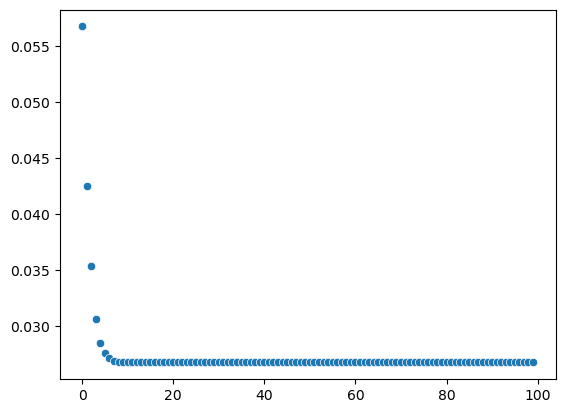

In [60]:
x =np.arange(num_iter)
species_ = 60
y = B_alone_mat

plt_ = sns.scatterplot(x=x, y=y)

In [46]:
Ri_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint'].copy()
abun_alone_tmp = np.zeros((num_species))
count_p = 7
for species_ in range(num_species):
    abun_alone_tmp[species_] = \
        np.sum(Ri_avg[count_p] * np.array(df_speciesMetab_cluster.iloc[species_, :].values))

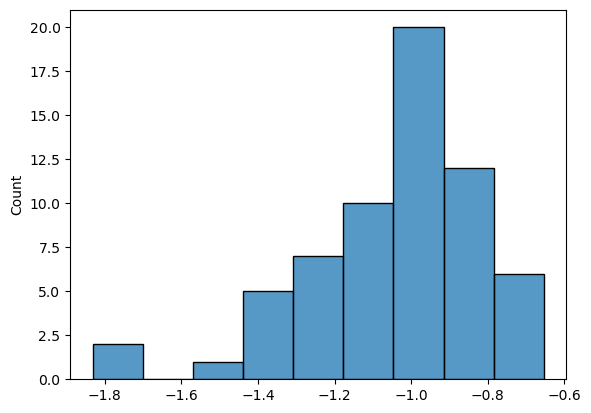

In [47]:
plt_ = sns.histplot(x=np.log10(abun_alone_tmp))

In [48]:
np.mean(abun_alone_tmp)

0.10188232518082392

In [25]:
## fit dynamic Ri for passage transition 1->2 and 2->3 for clustered metabs
date_ = '20230605'
date_ = '20230607'
n_repeats = 10
rand_seed = 7363
np.random.seed(rand_seed)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]


num_metabs_clust = df_speciesMetab.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_without_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_without_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))
Ri_dynamic_obj = {}
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_cluster, \
#                                 df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                 df_speciesAbun_ratio_mdl, p_vec_new, \
#                                 file_save, num_passages=5, pass_rm=[1, 2, 3, 4])
pass_keep = np.arange(num_passages - 1)
id_keep = list(pass_keep) + list(pass_keep + num_passages - 1) + list(pass_keep + 2 * (num_passages - 1))
pass_rm = [1, 2, 3, 4]
Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab_tmp, \
                                df_speciesAbun_prev_mdl.iloc[:, id_keep], \
                                df_speciesAbun_next_mdl.iloc[:, id_keep], \
                                df_speciesAbun_ratio_mdl.iloc[:, id_keep], p_vec_new, \
                                file_save, num_passages=5, pass_rm=pass_rm, num_brep=3, \
                                get_prod=False, B_alone=1e6, \
                                df_speciesMetab_prod=df_speciesMetab_prod_tmp)
# Ri_dynamic_obj = fit_dynamic_Ri(df_speciesMetab, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, p_vec_new, \
#                                       file_save, num_passages=5, pass_rm=[3, 4])
# Ri_dynamic_obj = fit_ss_Ri(df_speciesMetab, df_speciesAbun_mdl, \
#                                       df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                                       df_speciesAbun_ratio_mdl, \
#                                       file_save, num_passages=6, pass_rm=[0, 1, 2])
# Ri_ss_obj =  fit_ss_Ri(df_speciesMetab_cluster, df_speciesAbun_mdl, \
#                        df_speciesAbun_prev_mdl, df_speciesAbun_next_mdl, \
#                        df_speciesAbun_ratio_mdl, \
#                        file_save=file_save, num_passages=6, pass_rm=pass_rm)

with open(file_save, "wb") as file_:
     pickle.dump(Ri_dynamic_obj, file_) 

count = 0, p_tmp = 0.001
count = 1, p_tmp = 0.01
count = 2, p_tmp = 0.05
count = 3, p_tmp = 0.06
count = 4, p_tmp = 0.07
count = 5, p_tmp = 0.08
count = 6, p_tmp = 0.09
count = 7, p_tmp = 0.1
count = 8, p_tmp = 0.125
count = 9, p_tmp = 0.15
count = 10, p_tmp = 0.175
count = 11, p_tmp = 0.2
count = 12, p_tmp = 0.3
count = 13, p_tmp = 0.4
count = 14, p_tmp = 0.5
count = 15, p_tmp = 0.55
count = 16, p_tmp = 0.6
count = 17, p_tmp = 0.65
count = 18, p_tmp = 0.7


In [87]:
date_ = '20230605'
date_ = '20230607'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [83]:
count_p = 7
Ri_0 = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()

In [68]:
date_ = '20230605'
date_ = '20230607'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_with_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'_iterate_Balone.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [26]:
date_ = '20230605'
date_ = '20230607'
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_without_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_for_paper_Ri_fit_dynamic_without_production' + \
                                         f'_cluster_metabolites_new_hierachClust_{microcosm_type}' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    Ri_dynamic_obj = pickle.load(file_) 
    
Ri_noMicrocosm_dynamicAll_fit_all = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_all']
Ri_noMicrocosm_dynamicAll_fit_avg = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_avg']
Ri_noMicrocosm_dynamicAll_fit_joint = Ri_dynamic_obj['Ri_noMicrocosm_dynamicAll_fit_joint']

In [16]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
print(f'with production term')
df_metabs_clusters_order.iloc[range(20), :]

with production term


cluster_labels  cluster_counts  \
92              92               1   
7                7               7   
4                4              15   
37              37               1   
1                1              25   
2                2              30   
15              15               1   
19              19               1   
66              66               1   
88              88               1   
10              10               1   
24              24               1   
38              38               1   
80              80               1   
53              53               1   
90              90               1   
31              31               1   
36              36               1   
82              82               1   
25              25               1   

                                    cluster_metab_IDs  \
92                                              [218]   
7                        [3, 27, 34, 39, 65, 99, 110]   
4   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...   
37                                              [163]   
1   [1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...   
2   [0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...   
15                                              [141]   
19                                              [145]   
66                                              [192]   
88                                              [214]   
10                                              [136]   
24                                              [150]   
38                                              [164]   
80                                              [206]   
53                                              [179]   
90                                              [216]   
31                                              [157]   
36                                              [162]   
82                                              [208]   
25                                              [151]   

                                   cluser_metab_names        Ri  
92                                [PYROGLUTAMIC ACID]  0.146728  
7   [MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC...  0.121880  
4   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.065070  
37                                     [BETA-LACTOSE]  0.046727  
1   [NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ...  0.031973  
2   [N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI...  0.030306  
15                   [2-HYDROXY-2-METHYLBUTYRIC ACID]  0.026987  
19                                          [CYSTINE]  0.023954  
66                                         [CYTOSINE]  0.017412  
88                                           [PTERIN]  0.015981  
10                                    [GALACTOSAMINE]  0.015334  
24                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.015215  
38                            [IS_LEUCINE-5,5,5-D3_1]  0.014677  
80                               [N-ACETYLTRYPTOPHAN]  0.014578  
53                                           [3'-CMP]  0.014401  
90                                       [PYRIDOXINE]  0.013405  
31                                    [3-FUROIC ACID]  0.013269  
36                                    [DECANOIC ACID]  0.012995  
82                                 [N-BUTYRYLGLYCINE]  0.012177  
25                       [IS_4-BROMO-PHENYLALANINE_0]  0.011274

In [82]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
print(f'with production term')
df_metabs_clusters_order.iloc[range(20), :]

with production term


cluster_labels  cluster_counts  \
92              92               1   
7                7               7   
37              37               1   
4                4              15   
19              19               1   
15              15               1   
2                2              30   
10              10               1   
88              88               1   
1                1              25   
90              90               1   
36              36               1   
24              24               1   
31              31               1   
38              38               1   
66              66               1   
32              32               1   
82              82               1   
25              25               1   
57              57               1   

                                    cluster_metab_IDs  \
92                                              [218]   
7                        [3, 27, 34, 39, 65, 99, 110]   
37                                              [163]   
4   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...   
19                                              [145]   
15                                              [141]   
2   [0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...   
10                                              [136]   
88                                              [214]   
1   [1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...   
90                                              [216]   
36                                              [162]   
24                                              [150]   
31                                              [157]   
38                                              [164]   
66                                              [192]   
32                                              [158]   
82                                              [208]   
25                                              [151]   
57                                              [183]   

                                   cluser_metab_names        Ri  
92                                [PYROGLUTAMIC ACID]  0.117889  
7   [MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC...  0.073398  
37                                     [BETA-LACTOSE]  0.043024  
4   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.028282  
19                                          [CYSTINE]  0.024882  
15                   [2-HYDROXY-2-METHYLBUTYRIC ACID]  0.021228  
2   [N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI...  0.017356  
10                                    [GALACTOSAMINE]  0.015394  
88                                           [PTERIN]  0.014506  
1   [NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ...  0.012839  
90                                       [PYRIDOXINE]  0.011614  
36                                    [DECANOIC ACID]  0.011507  
24                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.010628  
31                                    [3-FUROIC ACID]  0.010432  
38                            [IS_LEUCINE-5,5,5-D3_1]  0.010042  
66                                         [CYTOSINE]  0.010037  
32                                    [MALEAMIC ACID]  0.009886  
82                                 [N-BUTYRYLGLYCINE]  0.008738  
25                       [IS_4-BROMO-PHENYLALANINE_0]  0.007179  
57  [5-AMINOIMIDAZOLE-4-CARBOXAMIDE-1-BETA-RIBOFUR...  0.006144

In [88]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})
print(f'with production term')
df_metabs_clusters_order.iloc[range(20), :]

with production term


cluster_labels  cluster_counts  \
92              92               1   
7                7               7   
37              37               1   
4                4              15   
19              19               1   
15              15               1   
2                2              30   
10              10               1   
88              88               1   
1                1              25   
90              90               1   
36              36               1   
24              24               1   
31              31               1   
38              38               1   
66              66               1   
32              32               1   
82              82               1   
25              25               1   
57              57               1   

                                    cluster_metab_IDs  \
92                                              [218]   
7                        [3, 27, 34, 39, 65, 99, 110]   
37                                              [163]   
4   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...   
19                                              [145]   
15                                              [141]   
2   [0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...   
10                                              [136]   
88                                              [214]   
1   [1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...   
90                                              [216]   
36                                              [162]   
24                                              [150]   
31                                              [157]   
38                                              [164]   
66                                              [192]   
32                                              [158]   
82                                              [208]   
25                                              [151]   
57                                              [183]   

                                   cluser_metab_names        Ri  
92                                [PYROGLUTAMIC ACID]  0.117795  
7   [MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC...  0.073329  
37                                     [BETA-LACTOSE]  0.042972  
4   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.028211  
19                                          [CYSTINE]  0.024886  
15                   [2-HYDROXY-2-METHYLBUTYRIC ACID]  0.021233  
2   [N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI...  0.017300  
10                                    [GALACTOSAMINE]  0.015409  
88                                           [PTERIN]  0.014505  
1   [NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ...  0.012800  
90                                       [PYRIDOXINE]  0.011597  
36                                    [DECANOIC ACID]  0.011485  
24                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.010621  
31                                    [3-FUROIC ACID]  0.010417  
38                            [IS_LEUCINE-5,5,5-D3_1]  0.010003  
66                                         [CYTOSINE]  0.009997  
32                                    [MALEAMIC ACID]  0.009884  
82                                 [N-BUTYRYLGLYCINE]  0.008739  
25                       [IS_4-BROMO-PHENYLALANINE_0]  0.007165  
57  [5-AMINOIMIDAZOLE-4-CARBOXAMIDE-1-BETA-RIBOFUR...  0.006143

In [27]:
count_p = 7
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
id_order = np.argsort(-Ri_avg)

num_metabs_clust = df_speciesMetab_cluster.shape[1]

df_metabs_clusters_order = df_metabs_clusters.copy()
df_metabs_clusters_order = df_metabs_clusters_order.iloc[id_order, :]
df_metabs_clusters_order['Ri'] = Ri_avg[id_order]

# df_metabs_tmp = pd.DataFrame(data={"metabs" : metab_names[id_order], \
#                                    "Ri" : Ri_avg[id_order]})

print(f'without production term')
df_metabs_clusters_order.iloc[range(20), :]

without production term


cluster_labels  cluster_counts  \
7                7               7   
92              92               1   
4                4              15   
53              53               1   
37              37               1   
1                1              25   
2                2              30   
15              15               1   
80              80               1   
19              19               1   
66              66               1   
24              24               1   
82              82               1   
52              52               1   
36              36               1   
38              38               1   
10              10               1   
31              31               1   
25              25               1   
90              90               1   

                                    cluster_metab_IDs  \
7                        [3, 27, 34, 39, 65, 99, 110]   
92                                              [218]   
4   [5, 13, 18, 19, 20, 22, 23, 45, 56, 57, 82, 85...   
53                                              [179]   
37                                              [163]   
1   [1, 6, 7, 24, 48, 62, 64, 66, 78, 83, 86, 90, ...   
2   [0, 16, 25, 26, 28, 30, 37, 38, 40, 41, 43, 46...   
15                                              [141]   
80                                              [206]   
19                                              [145]   
66                                              [192]   
24                                              [150]   
82                                              [208]   
52                                              [178]   
36                                              [162]   
38                                              [164]   
10                                              [136]   
31                                              [157]   
25                                              [151]   
90                                              [216]   

                                   cluser_metab_names        Ri  
7   [MANNOSE 6-PHOSPHATE, GLUCOSE, SUCROSE_1, GLYC...  0.159437  
92                                [PYROGLUTAMIC ACID]  0.154513  
4   [BETA-ALANINE_0, OMEGA-HYDROXYDODECANOIC ACID,...  0.095693  
53                                           [3'-CMP]  0.050134  
37                                     [BETA-LACTOSE]  0.048145  
1   [NICOTINIC ACID, 1-METHYL-HYDANTOIN, SUCCINIC ...  0.040561  
2   [N-METHYL-ASPARTIC ACID_0, STEARIC ACID, CITRI...  0.036109  
15                   [2-HYDROXY-2-METHYLBUTYRIC ACID]  0.032078  
80                               [N-ACETYLTRYPTOPHAN]  0.025078  
19                                          [CYSTINE]  0.023577  
66                                         [CYTOSINE]  0.020506  
24                  [IS_PHENYLALANINE-2,3,4,5,6-D5_1]  0.016207  
82                                 [N-BUTYRYLGLYCINE]  0.015085  
52                           [2-METHYLBUTYRYLGLYCINE]  0.014870  
36                                    [DECANOIC ACID]  0.013964  
38                            [IS_LEUCINE-5,5,5-D3_1]  0.013855  
10                                    [GALACTOSAMINE]  0.013747  
31                                    [3-FUROIC ACID]  0.013278  
25                       [IS_4-BROMO-PHENYLALANINE_0]  0.011747  
90                                       [PYRIDOXINE]  0.010891

In [89]:
# evalute Ri with production
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
# count_p = 7

RMSE_mat_full = np.zeros((num_passages, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all_prod, RMSE_obj_all_prod = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=abun_alone, \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                             prod_use_prev=False)
for pass_ in range(num_passages):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all_prod[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all_prod[pass_]["growth_ratio"]

In [18]:
RMSE_mat_full

array([[1.44266898, 1.42339144],
       [1.55383768, 0.95536658],
       [1.87504228, 1.33563993],
       [2.13323819, 1.54562059],
       [2.33593176, 1.45198082],
       [2.50741688, 1.44984833]])

In [52]:
RMSE_mat_full

array([[1.43967378, 1.42554595],
       [1.54856144, 0.96253975],
       [1.85682383, 1.31319757],
       [2.16126817, 1.52988439],
       [2.37462147, 1.4428883 ],
       [2.56441509, 1.44825573]])

In [73]:
RMSE_mat_full

array([[1.43888576, 1.42462512],
       [1.54401853, 0.95650266],
       [1.84332644, 1.30569838],
       [2.13135807, 1.52977176],
       [2.35158785, 1.43051101],
       [2.53138667, 1.43641941]])

In [81]:
RMSE_mat_full

array([[1.43987936, 1.42610901],
       [1.54468185, 0.95628044],
       [1.84439991, 1.30642439],
       [2.1327783 , 1.52996466],
       [2.35370653, 1.43022913],
       [2.53341209, 1.43599559]])

In [90]:
RMSE_mat_full

array([[1.43979015, 1.42597761],
       [1.54464398, 0.95630158],
       [1.844337  , 1.30624649],
       [2.13282327, 1.52985188],
       [2.35368101, 1.43020052],
       [2.53349461, 1.43604644]])

In [93]:
Ri_tmp = Ri_0 / np.sum(Ri_0)
1 / np.sum(Ri_tmp**2)

9.97496880463799

In [22]:
# prediction performance with production
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(2, 3, figsize=(40, 35), sharey="row", sharex=None)
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(4):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all_prod[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all_prod[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_with_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_passage1to2_predict_with_inoc_with_production.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0
row = 0, col = 1
row = 0, col = 2


/tmp/ipykernel_114770/2489944795.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_114770/2489944795.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_114770/2489944795.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_114770/2489944795.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 1, col = 0


/tmp/ipykernel_114770/2489944795.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_114770/2489944795.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


In [28]:
# evalute Ri without production
num_metabs_clust = df_speciesMetab_cluster.shape[1]
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
count_p = 7

RMSE_mat_full = np.zeros((num_passages, 2))
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_fit = {0: Ri_avg}
# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_all, RMSE_obj_all = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc, df_speciesAbun_mdl, \
                             df_speciesAbun_prev_mdl, \
                             df_speciesAbun_ratio_mdl, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=False, B_alone=None, \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                             prod_use_prev=False)
for pass_ in range(num_passages):
    RMSE_mat_full[pass_, 0] = RMSE_obj_all[pass_]["abundance"]
    RMSE_mat_full[pass_, 1] = RMSE_obj_all[pass_]["growth_ratio"]

In [29]:
RMSE_mat_full

array([[1.48685829, 1.4682865 ],
       [1.64036302, 0.93701365],
       [1.97260391, 1.40485852],
       [2.2105038 , 1.63852835],
       [2.3720601 , 1.52728912],
       [2.52502056, 1.51030446]])

In [100]:
RMSE_1 = np.array([[1.44266898, 1.42339144],
       [1.55383768, 0.95536658],
       [1.87504228, 1.33563993],
       [2.13323819, 1.54562059],
       [2.33593176, 1.45198082],
       [2.50741688, 1.44984833]])

RMSE_2 = np.array([[1.48685829, 1.4682865 ],
       [1.64036302, 0.93701365],
       [1.97260391, 1.40485852],
       [2.2105038 , 1.63852835],
       [2.3720601 , 1.52728912],
       [2.52502056, 1.51030446]])

(np.abs(RMSE_1 - RMSE_2) / RMSE_2) * 100

array([[2.97199204, 3.05764985],
       [5.27476778, 1.95866197],
       [4.9458297 , 4.92708618],
       [3.49538463, 5.67019545],
       [1.52307861, 4.93084767],
       [0.69716977, 4.00291012]])

In [30]:
# prediction performance without production
num_iter = 100
# fig, axes = plt.subplots(2, int(num_passages / 2), \
#                              figsize=(40, 35), sharey="row", sharex="col")
fig, axes = plt.subplots(2, 3, figsize=(40, 35), sharey="row", sharex=None)
fig.supylabel('predicted abundance (log scale)', fontsize=60)
fig.supxlabel('observed abundance (log scale)', fontsize=60)
for pass_ in range(4):
    ax_row_ = int(pass_ / 3)
    ax_col_ = int(pass_ % 3)
    print(f'row = {ax_row_}, col = {ax_col_}')

    b_ = range(3)
    x = sens_obj_all[pass_]['df_speciesAbun_next_obs']
#     x = 10**(np.mean(np.log10(x), axis=1)).flatten()
    x = x.flatten()
    y = sens_obj_all[pass_]['df_speciesAbun_next_pred']
    thresh_zero = 1e-8
    y[y == 0] = thresh_zero
    id_ = np.where((x > 0) & (y > 0))[0]
    id_ord = np.where((x > 0) & (y > 0))[0]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    y[y <= -8] = -8

    plt_ = sns.scatterplot(x=x, \
                            y=y, s=100, ax=axes[ax_row_, ax_col_])

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[ax_row_, ax_col_])
    plt_.plot([-8, 0], [-8, 0], c="red", linewidth=3)

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    # abs_mean_error = np.median(np.abs(y - x))
    abs_mean_error = np.sqrt(np.mean(np.power(y - x, 2)))
    std_error = np.sqrt(np.std(np.power(y - x, 2)))

    id_notzero_zero = np.where((x > -8) & (y <= -8))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(10**y, 10**x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]

    model_log = sm.OLS(y, x).fit()
    slope_log = model_log.params[0]
    slope_log_pval = model_log.pvalues[0]

    # plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
    plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="green", \
                linewidth=3)

    # title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe[1]) + \
    #         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_pe_log[1]) + \
    #         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
    #                 '{:.3e}'.format(corr_val_sp[1]) + \
    #         f'\n slope = {np.round(slope, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_pval) + \
    #         f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
    #                 '{:.3e}'.format(slope_log_pval) + \
    #         f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
    #         f'\n fit with p = {p_tmp}'
    title_ = f'predicted vs observed abundance at passage {pass_ + 1}' + \
            f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
            f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                    '{:.3e}'.format(slope_log_pval) + \
            f'\n RMSE = {np.round(abs_mean_error, 3)}'

    axes[ax_row_, ax_col_].set_title(title_, size=30)
#     if ax_row_ == 1:
#         plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
    if ax_col_ == 0:
        plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
    plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_meeting}_for_paper_' + \
                                        f'_Ri_fit_dynamic_without_production' + \
                                        f'_cluster_metabolites_new_{nclusts}hierachClust_{microcosm_type}' + \
                                        f'_pass_1to2'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

file_save = os.path.abspath(os.path.join(save_dir, 
                                            f'predicted_vs_observed_abundance_' + \
                                            f'Ri_fit_passage1to2_predict_with_inoc_without_production.png'))

fig.figure.savefig(file_save, \
                    dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

row = 0, col = 0
row = 0, col = 1
row = 0, col = 2


/tmp/ipykernel_114770/1791971660.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_114770/1791971660.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_114770/1791971660.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)
/tmp/ipykernel_114770/1791971660.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


row = 1, col = 0


/tmp/ipykernel_114770/1791971660.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=40)
/tmp/ipykernel_114770/1791971660.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=40)


# keystone species analysis: with production

In [19]:
def species_mean(id_species_full, x, y, num_species):
    x_mean = np.zeros((num_species))
    y_mean = np.zeros_like(x_mean)
    
    for s_ in range(num_species):
        id_ = np.where(id_species_full == s_)[0]
        x_mean[s_] = np.exp(np.mean(np.log(x[id_])))
        y_mean[s_] = np.exp(np.mean(np.log(y[id_])))
        
    return x_mean, y_mean

In [20]:
def find_perturbed_species(x, y, thresh_=1):
    id_species = np.where(np.abs(np.log10(x) - np.log10(y)) >= thresh_)[0]
    id_species_type = np.zeros((len(id_species)))
    id_species_type[(np.log10(x) - np.log10(y))[id_species] < 0] = 1
    
    return id_species, id_species_type

In [21]:
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log(abun_avg_pass_3), axis=1)
id_species_order = np.argsort(-abun_avg_pass_3)

RMSE_mat_full = np.zeros((num_passages, 2))

s_ = id_species_order[3]

id_species_full = np.arange((num_species)).reshape((num_species, 1))
id_species_full = np.hstack([id_species_full, id_species_full, id_species_full]).flatten()
# for count_, s_ in enumerate(id_species_order):

for count_, s_ in enumerate(id_species_order):
    print(f'loop = {count_}, species perturbed = {s_}')
    df_speciesAbun_inoc_tmp = df_speciesAbun_inoc.copy()
    df_speciesAbun_inoc_tmp.iloc[s_, :] = 0
    df_speciesAbun_tmp = df_speciesAbun_mdl.copy()
    df_speciesAbun_tmp.iloc[s_, :] = 0
    df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy()
    df_speciesAbun_prev_tmp.iloc[s_, :] = 0
    df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy()
    df_speciesAbun_ratio_tmp.iloc[s_, :] = 1

    id_metabs_keep = metabs_to_remove_knockdown_species(df_speciesMetab_cluster, [s_])
    Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
    Ri_avg = Ri_avg[id_metabs_keep]
    Ri_fit = {0: Ri_avg}

    num_metabs_clust = df_speciesMetab_cluster.shape[1] - 1
    df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
    df_speciesMetab_tmp = df_speciesMetab_tmp.iloc[:, id_metabs_keep]
    df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
    df_speciesMetab_prod_tmp = df_speciesMetab_prod_tmp.iloc[:, id_metabs_keep]
    count_p = 7

    # RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
    sens_obj_knock, RMSE_obj_knock = \
        blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                                 df_speciesAbun_inoc_tmp, df_speciesAbun_tmp, \
                                 df_speciesAbun_prev_tmp, \
                                 df_speciesAbun_ratio_tmp, \
                                 Ri_fit, "dummy", "dummy", \
                                 "dummy", num_passages=6, num_iter=100, \
                                 thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                                 save_data_obj=False, \
                                 return_sensitivity_ana=True, \
                                 get_prod=True, B_alone=0.5, \
                                 df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                                 prod_use_prev=False)
    y = sens_obj_knock[2]['df_speciesAbun_next_pred'].copy()
    x = sens_obj_all_prod[2]['df_speciesAbun_next_pred'].copy()
    x[x <= 1e-8] = 1e-8
    y[y <= 1e-8] = 1e-8
    x_mean, y_mean = species_mean(id_species_full, x, y, num_species)
    
    id_species, id_species_type = \
        find_perturbed_species(x_mean, y_mean, thresh_=1)
    df_perturb_tmp = pd.DataFrame(data={"species_knocked" : [s_] * len(id_species), \
                                        "species_perturbed" : id_species, \
                                        "species_perturbed_type" : id_species_type, \
                                        "species_unperturbed_abun" : x_mean[id_species], \
                                        "species_perturbed_abun" : y_mean[id_species]})
    if count_ == 0:
        df_perturb_net = df_perturb_tmp.copy()
    else:
        df_perturb_net = pd.concat([df_perturb_net, df_perturb_tmp])
    
    

loop = 0, species perturbed = 1


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWarning: divide by zero encountered in log10
  ratio_init += np.mean(np.log10(ratio_init_rand), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1630: RuntimeWarning: divide by zero encountered in log10
  x = 10**np.mean(np.log10(x), axis=1).flatten()
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1631: RuntimeWarning: invalid value encountered in divide
  x /= np.array(df_speciesAbun_inoc).flatten()
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: div

loop = 1, species perturbed = 8


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 2, species perturbed = 22


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 3, species perturbed = 23


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 4, species perturbed = 21


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 5, species perturbed = 51


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 6, species perturbed = 15


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 7, species perturbed = 45


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 8, species perturbed = 2


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 9, species perturbed = 55


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 10, species perturbed = 13


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 11, species perturbed = 17


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 12, species perturbed = 32


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 13, species perturbed = 25


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 14, species perturbed = 58


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 15, species perturbed = 11


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 16, species perturbed = 16


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 17, species perturbed = 33


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 18, species perturbed = 60


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 19, species perturbed = 7


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 20, species perturbed = 54


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 21, species perturbed = 31


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 22, species perturbed = 42


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 23, species perturbed = 20


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 24, species perturbed = 56


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 25, species perturbed = 12


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 26, species perturbed = 18


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 27, species perturbed = 38


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 28, species perturbed = 19


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 29, species perturbed = 36


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 30, species perturbed = 39


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 31, species perturbed = 41


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 32, species perturbed = 24


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 33, species perturbed = 0


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 34, species perturbed = 29


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 35, species perturbed = 59


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 36, species perturbed = 4


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 37, species perturbed = 48


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 38, species perturbed = 9


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 39, species perturbed = 52


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 40, species perturbed = 10


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 41, species perturbed = 53


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 42, species perturbed = 44


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 43, species perturbed = 34


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 44, species perturbed = 49


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 45, species perturbed = 5


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 46, species perturbed = 50


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 47, species perturbed = 37


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 48, species perturbed = 14


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 49, species perturbed = 6


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 50, species perturbed = 35


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 51, species perturbed = 3


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 52, species perturbed = 28


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 53, species perturbed = 26


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 54, species perturbed = 61


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 55, species perturbed = 43


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 56, species perturbed = 40


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 57, species perturbed = 27


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 58, species perturbed = 57


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 59, species perturbed = 30


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 60, species perturbed = 47


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 61, species perturbed = 46


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWa

loop = 62, species perturbed = 62


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)


In [29]:
df_perturb_net['species_abun_obs'] = np.exp(abun_avg_pass_3[df_perturb_net['species_perturbed'].values])

In [30]:
np.exp(abun_avg_pass_3)[1]

0.2892740182944301

In [31]:
x_obs = df_perturb_net['species_abun_obs'].values
x = df_perturb_net['species_unperturbed_abun'].values
y = df_perturb_net['species_perturbed_abun'].values
id_filter = np.where((np.abs(np.log10(x) - np.log10(x_obs)) - np.abs(np.log10(y) - np.log10(x_obs)) <= -1))[0]
df_perturb_net_filter = df_perturb_net.copy()
df_perturb_net_filter = df_perturb_net_filter.iloc[id_filter, :]

In [32]:
df_perturb_net_filter

species_knocked  species_perturbed  species_perturbed_type  \
1               1.0                  1                     0.0   
3               1.0                 11                     1.0   
5               1.0                 14                     1.0   
6               1.0                 15                     0.0   
7               1.0                 16                     0.0   
..              ...                ...                     ...   
0               0.0                  0                     0.0   
0              29.0                 29                     0.0   
0              59.0                 59                     0.0   
0              52.0                 52                     0.0   
0              10.0                 10                     0.0   

    species_unperturbed_abun  species_perturbed_abun  species_abun_obs  
1               2.310819e-01            1.000000e-08      2.892740e-01  
3               6.790343e-03            1.539158e-01      4.478012e-03  
5               4.203913e-07            3.476536e-02      9.879512e-08  
6               1.959454e-05            4.398482e-08      4.562163e-02  
7               5.777844e-05            8.292003e-08      3.846872e-03  
..                       ...                     ...               ...  
0               1.529766e-06            1.000000e-08      7.820539e-05  
0               2.948857e-05            1.000000e-08      4.265375e-05  
0               2.470812e-06            1.000000e-08      1.902855e-05  
0               2.021579e-05            1.000000e-08      7.562355e-06  
0               1.494235e-06            1.000000e-08      6.367910e-06  

[74 rows x 6 columns]

In [41]:
G = nx.DiGraph()
id_species_order = np.argsort(abun_avg_pass_3)
species_order = np.arange(num_species)
species_order[id_species_order] = (np.arange(num_species) / num_species) * 1000
for s_ in range(num_species):
    if np.abs(np.log10(x_mean[s_]) - np.log10(np.exp(abun_avg_pass_3[s_]))) < 1:
        col_ = "green"
    else:
        col_ = "gray"
    G.add_nodes_from([(s_, {"abundance_obs" : species_order[s_], "node_color" : col_})])

In [42]:
edges_ = []
for row_ in range(df_perturb_net_filter.shape[0]):
    src_ = df_perturb_net_filter['species_knocked'].values[row_]
    dest_ = df_perturb_net_filter['species_perturbed'].values[row_]
    
    if src_ != dest_:
#         print(f'row = {row_}')
        type_ = df_perturb_net_filter['species_perturbed_type'].values[row_]
        if type_ == 1:
            col_ = "red"
        else:
            col_ = "blue"
        weight_ = np.abs(np.log10(df_perturb_net_filter['species_unperturbed_abun'].values[row_]) - \
                         np.log10(df_perturb_net_filter['species_perturbed_abun'].values[row_]))
        edges_.append((src_, dest_, {'increased abundance': col_, 'weight' : weight_}))
G.add_edges_from(edges_)

In [43]:
G.number_of_edges()

38

In [44]:
G.nodes.data()

NodeDataView({0: {'abundance_obs': 460, 'node_color': 'gray'}, 1: {'abundance_obs': 984, 'node_color': 'green'}, 2: {'abundance_obs': 857, 'node_color': 'green'}, 3: {'abundance_obs': 174, 'node_color': 'green'}, 4: {'abundance_obs': 412, 'node_color': 'gray'}, 5: {'abundance_obs': 269, 'node_color': 'gray'}, 6: {'abundance_obs': 206, 'node_color': 'green'}, 7: {'abundance_obs': 682, 'node_color': 'gray'}, 8: {'abundance_obs': 968, 'node_color': 'gray'}, 9: {'abundance_obs': 380, 'node_color': 'gray'}, 10: {'abundance_obs': 349, 'node_color': 'green'}, 11: {'abundance_obs': 746, 'node_color': 'green'}, 12: {'abundance_obs': 587, 'node_color': 'green'}, 13: {'abundance_obs': 825, 'node_color': 'green'}, 14: {'abundance_obs': 222, 'node_color': 'green'}, 15: {'abundance_obs': 888, 'node_color': 'gray'}, 16: {'abundance_obs': 730, 'node_color': 'gray'}, 17: {'abundance_obs': 809, 'node_color': 'green'}, 18: {'abundance_obs': 571, 'node_color': 'green'}, 19: {'abundance_obs': 539, 'node_co

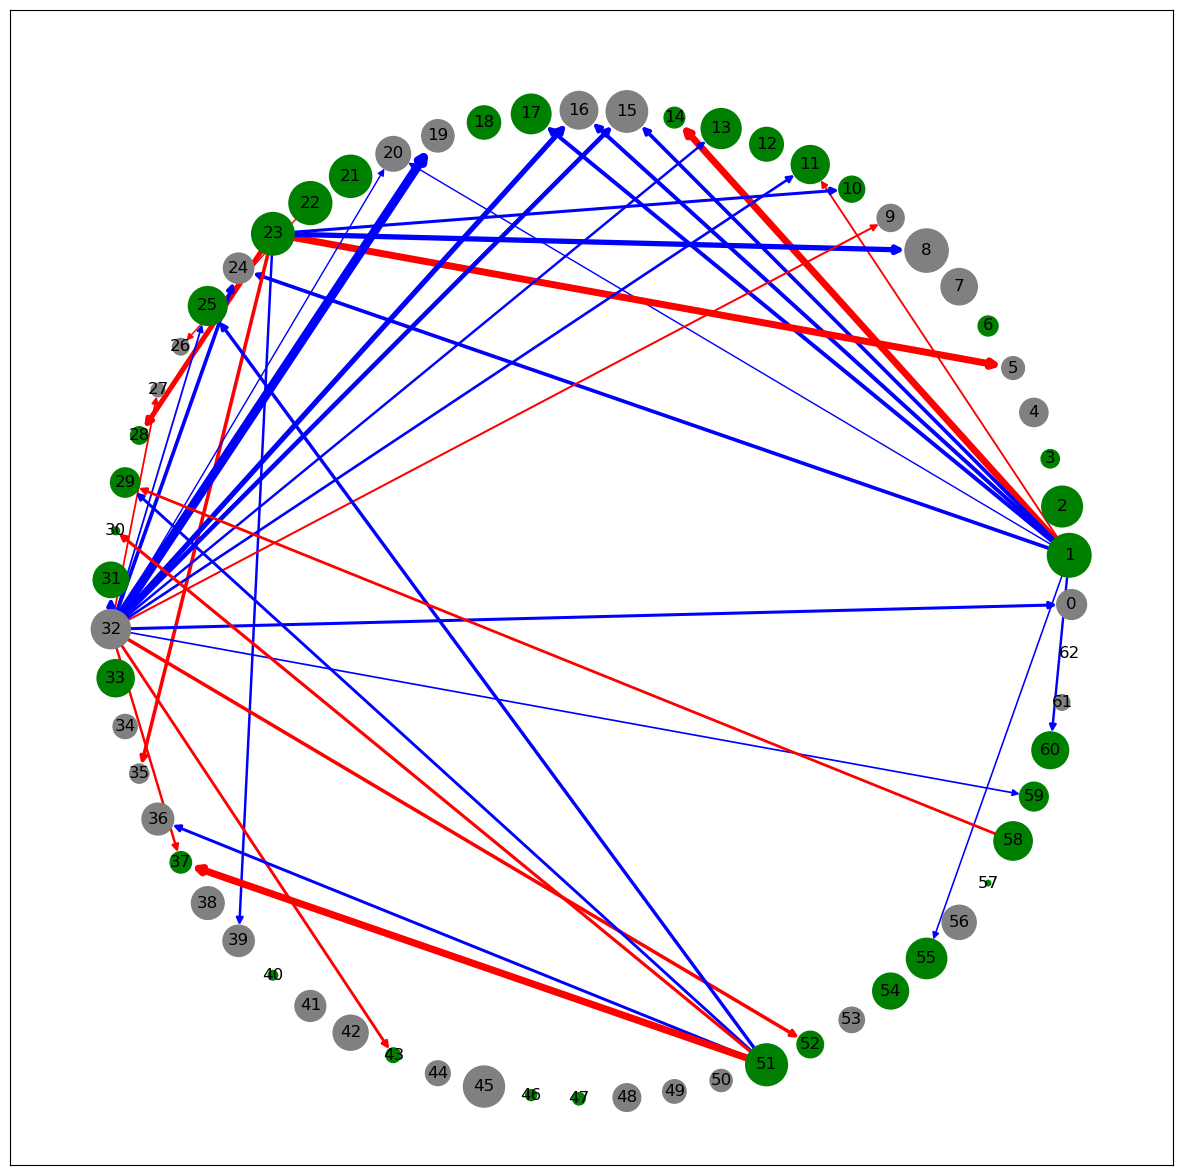

In [45]:
edges = G.edges()
nodes_ = G.nodes()
colors = [G[u][v]['increased abundance'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
node_size_ = [u[1]['abundance_obs'] for u in G.nodes.data()]
node_color_ = [u[1]['node_color'] for u in G.nodes.data()]
pos = nx.circular_layout(G)

plt.rcParams["figure.figsize"] = (15,15)
plt_ = nx.draw_networkx(G, pos, edge_color=colors, width=weights, node_size=node_size_, \
                        node_color=node_color_)

In [ ]:
id_ = np.where((df_perturb_net_filter['species_knocked'] == 51))[0]
df_perturb_net_filter

In [33]:
df_perturb_net_filter

species_knocked  species_perturbed  species_perturbed_type  \
1               1.0                  1                     0.0   
3               1.0                 11                     1.0   
5               1.0                 14                     1.0   
6               1.0                 15                     0.0   
7               1.0                 16                     0.0   
..              ...                ...                     ...   
0               0.0                  0                     0.0   
0              29.0                 29                     0.0   
0              59.0                 59                     0.0   
0              52.0                 52                     0.0   
0              10.0                 10                     0.0   

    species_unperturbed_abun  species_perturbed_abun  species_abun_obs  
1               2.310819e-01            1.000000e-08      2.892740e-01  
3               6.790343e-03            1.539158e-01      4.478012e-03  
5               4.203913e-07            3.476536e-02      9.879512e-08  
6               1.959454e-05            4.398482e-08      4.562163e-02  
7               5.777844e-05            8.292003e-08      3.846872e-03  
..                       ...                     ...               ...  
0               1.529766e-06            1.000000e-08      7.820539e-05  
0               2.948857e-05            1.000000e-08      4.265375e-05  
0               2.470812e-06            1.000000e-08      1.902855e-05  
0               2.021579e-05            1.000000e-08      7.562355e-06  
0               1.494235e-06            1.000000e-08      6.367910e-06  

[74 rows x 6 columns]

In [45]:
species_names_sorted = species_names[id_species_order]
df_species = pd.DataFrame(data={"id" : np.arange(num_species), \
                                "species" : species_names_sorted})
for row_ in range(df_species.shape[0]):
    print(f'id = {row_}, species = {species_names[row_]}')
    

id = 0, species = Acidaminococcus fermentans DSMZ 20731
id = 1, species = Acidaminococcus intestini D21 BEI HM-81
id = 2, species = Anaerostipes caccae DSMZ 14662
id = 3, species = Anaerotruncus colihominis DSMZ 17241
id = 4, species = Bacteroides caccae ATCC 43185
id = 5, species = Bacteroides cellulosilyticus DSMZ 14838
id = 6, species = Bacteroides coprophilus DSMZ 18228
id = 7, species = Bacteroides dorei 5_1_36/D4 BEI HM-29
id = 8, species = Bacteroides dorei DSMZ 17855
id = 9, species = Bacteroides eggerthii ATCC 27754
id = 10, species = Bacteroides finegoldii DSMZ 17565
id = 11, species = Bacteroides fragilis 3_1_12 BEI HM-20
id = 12, species = Bacteroides intestinalis DSMZ 17393
id = 13, species = Bacteroides ovatus ATCC 8483
id = 14, species = Bacteroides plebeius DSMZ 17135
id = 15, species = Bacteroides sp. 1_1_6 BEI HM-23
id = 16, species = Bacteroides sp. 2_1_16 BEI HM-58
id = 17, species = Bacteroides sp. 2_1_22 BEI HM-18
id = 18, species = Bacteroides sp. 3_1_19 BEI HM-1

In [46]:
id_species_order = np.argsort(-abun_avg_pass_3)
id_species_order

array([ 1,  8, 22, 23, 21, 51, 15, 45,  2, 55, 13, 17, 32, 25, 58, 11, 16,
       33, 60,  7, 54, 31, 42, 20, 56, 12, 18, 38, 19, 36, 39, 41, 24,  0,
       29, 59,  4, 48,  9, 52, 10, 53, 44, 34, 49,  5, 50, 37, 14,  6, 35,
        3, 28, 26, 61, 43, 40, 27, 57, 30, 47, 46, 62])

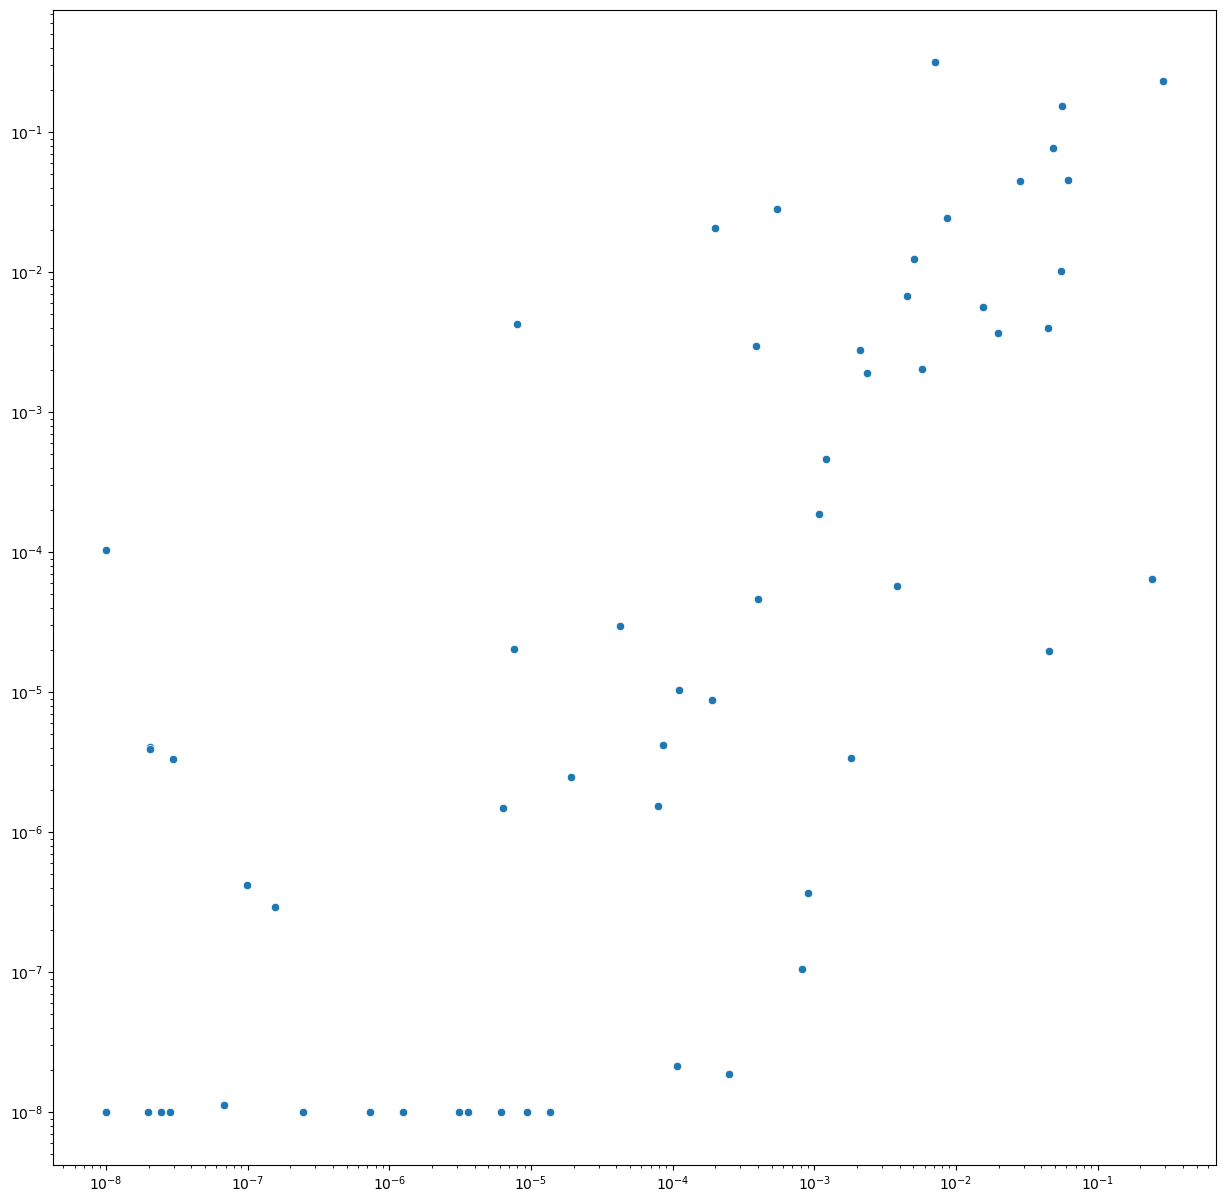

In [47]:
y = x_mean.copy()
x = np.exp(abun_avg_pass_3).copy()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [48]:
id_ = np.where((y <= 1e-8) & (x > 1e-8))[0]
id_

array([], dtype=int64)

In [49]:
x[53]

6.126501166090867e-06

In [50]:
x_obs = df_perturb_net['species_abun_obs'].values
x = df_perturb_net['species_unperturbed_abun'].values
y = df_perturb_net['species_perturbed_abun'].values
id_filter = np.where((np.abs(np.log10(x) - np.log10(x_obs)) - np.abs(np.log10(y) - np.log10(x_obs)) > -1))[0]
df_perturb_net_filter = df_perturb_net.copy()
df_perturb_net_filter = df_perturb_net_filter.iloc[id_filter, :]

In [51]:
G = nx.DiGraph()
id_species_order = np.argsort(abun_avg_pass_3)
species_order = np.arange(num_species)
species_order[id_species_order] = (np.arange(num_species) / num_species) * 1000
for s_ in range(num_species):
    if np.abs(np.log10(x_mean[s_]) - np.log10(np.exp(abun_avg_pass_3[s_]))) < 1:
        col_ = "green"
    else:
        col_ = "gray"
    G.add_nodes_from([(s_, {"abundance_obs" : species_order[s_], "node_color" : col_})])

In [52]:
edges_ = []
for row_ in range(df_perturb_net_filter.shape[0]):
    src_ = df_perturb_net_filter['species_knocked'].values[row_]
    dest_ = df_perturb_net_filter['species_perturbed'].values[row_]
    
    if src_ != dest_:
        type_ = df_perturb_net_filter['species_perturbed_type'].values[row_]
        if type_ == 1:
            col_ = "red"
        else:
            col_ = "blue"
        weight_ = np.abs(np.log10(df_perturb_net_filter['species_unperturbed_abun'].values[row_]) - \
                         np.log10(df_perturb_net_filter['species_perturbed_abun'].values[row_]))
        edges_.append((src_, dest_, {'increased abundance': col_, 'weight' : weight_}))
G.add_edges_from(edges_)

In [53]:
G.number_of_edges()

27

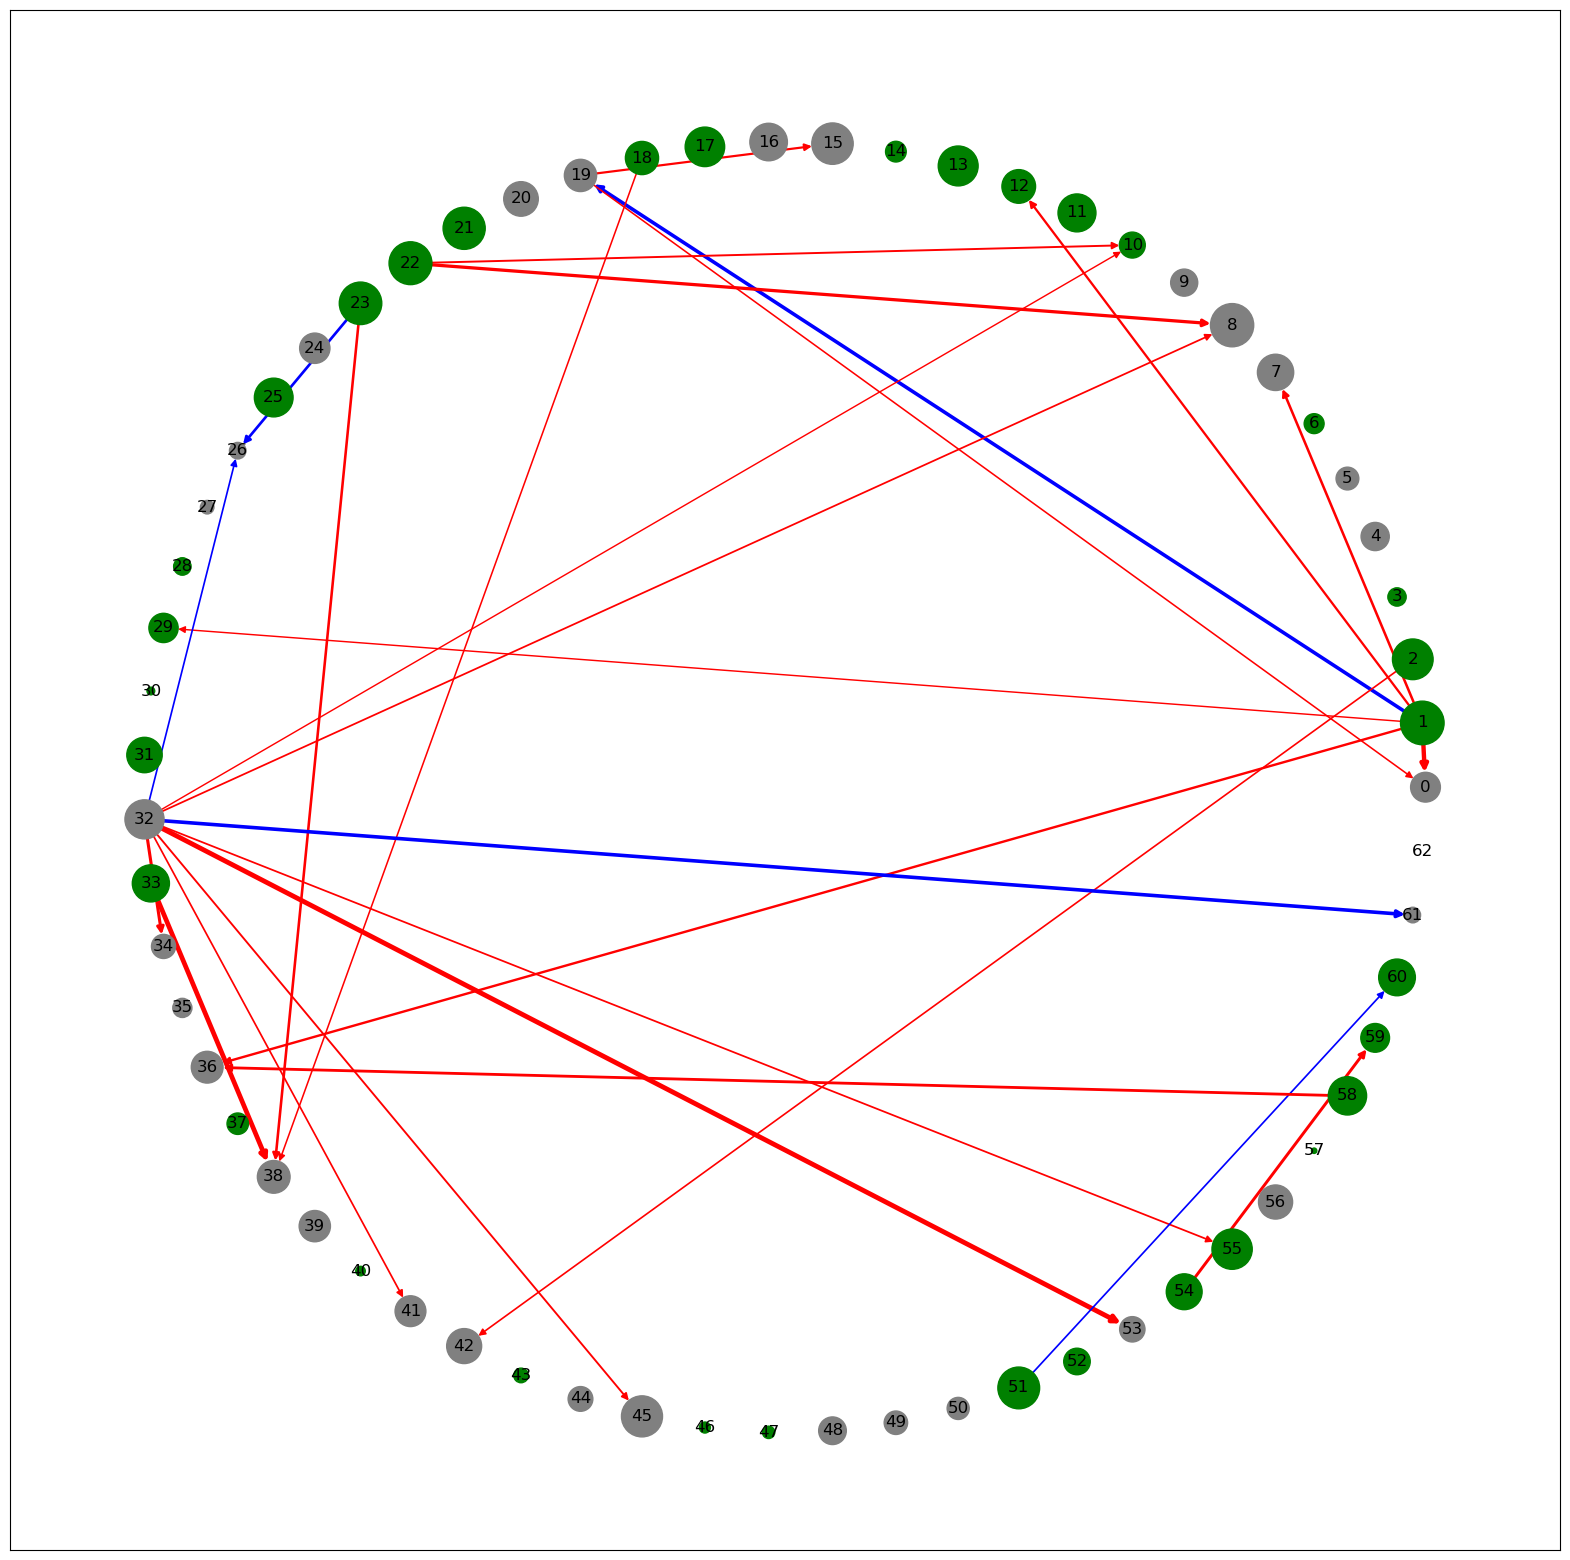

In [54]:
edges = G.edges()
nodes_ = G.nodes()
colors = [G[u][v]['increased abundance'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
node_size_ = [u[1]['abundance_obs'] for u in G.nodes.data()]
node_color_ = [u[1]['node_color'] for u in G.nodes.data()]
pos = nx.circular_layout(G)

plt.rcParams["figure.figsize"] = (20,20)
plt_ = nx.draw_networkx(G, pos, edge_color=colors, width=weights, node_size=node_size_, \
                        node_color=node_color_)

In [26]:
pass_keep = remove_passages(pass_rm_list=[0, 1, 3, 4, 5])
abun_avg_pass_3 = np.array(df_speciesAbun_mdl.iloc[:, pass_keep])
abun_avg_pass_3 = np.mean(np.log(abun_avg_pass_3), axis=1)
id_species_order = np.argsort(-abun_avg_pass_3)
s_ = id_species_order[0]
df_speciesAbun_inoc_tmp = df_speciesAbun_inoc.copy()
df_speciesAbun_inoc_tmp.iloc[s_, :] = 0
df_speciesAbun_tmp = df_speciesAbun_mdl.copy()
df_speciesAbun_tmp.iloc[s_, :] = 0
df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy()
df_speciesAbun_prev_tmp.iloc[s_, :] = 0
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy()
df_speciesAbun_ratio_tmp.iloc[s_, :] = 1

id_metabs_keep = metabs_to_remove_knockdown_species(df_speciesMetab_cluster, [s_])
Ri_avg = Ri_noMicrocosm_dynamicAll_fit_joint[count_p].copy()
Ri_avg = Ri_avg[id_metabs_keep]
Ri_fit = {0: Ri_avg}

num_metabs_clust = df_speciesMetab_cluster.shape[1] - 1
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
df_speciesMetab_tmp = df_speciesMetab_tmp.iloc[:, id_metabs_keep]
df_speciesMetab_prod_tmp = df_speciesMetab_prod_cluster.copy()
df_speciesMetab_prod_tmp = df_speciesMetab_prod_tmp.iloc[:, id_metabs_keep]
count_p = 7

# RMSE_sens_complete_full = np.zeros((num_passages - 1, 2))
sens_obj_knock, RMSE_obj_knock = \
    blindly_pred_abun_growth([p_vec_new[count_p]], df_speciesMetab_tmp, \
                             df_speciesAbun_inoc_tmp, df_speciesAbun_tmp, \
                             df_speciesAbun_prev_tmp, \
                             df_speciesAbun_ratio_tmp, \
                             Ri_fit, "dummy", "dummy", \
                             "dummy", num_passages=6, num_iter=100, \
                             thresh_zero=1e-8, Ri_ss=False, plot_=False, \
                             save_data_obj=False, \
                             return_sensitivity_ana=True, \
                             get_prod=True, B_alone=0.5, \
                             df_speciesMetab_prod=df_speciesMetab_prod_tmp, \
                             prod_use_prev=False)
y = sens_obj_knock[2]['df_speciesAbun_next_pred'].copy()
x = sens_obj_all_prod[2]['df_speciesAbun_next_pred'].copy()
x[x <= 1e-8] = 1e-8
y[y <= 1e-8] = 1e-8
x_mean, y_mean = species_mean(id_species_full, x, y, num_species)

id_species, id_species_type = \
    find_perturbed_species(x_mean, y_mean, thresh_=1)
# df_perturb_tmp = pd.DataFrame(data={"species_knocked" : [s_] * len(id_species), \
#                                     "species_perturbed" : id_species, \
#                                     "species_perturbed_type" : id_species_type, \
#                                     "species_unperturbed_abun" : x_mean[id_species], \
#                                     "species_perturbed_abun" : y_mean[id_species]})
# if count_ == 0:
#     df_perturb_net = df_perturb_tmp.copy()
# else:
#     df_perturb_net = pd.concat([df_perturb_net, df_perturb_tmp])


/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1330: RuntimeWarning: divide by zero encountered in log10
  ratio_init += np.mean(np.log10(ratio_init_rand), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1630: RuntimeWarning: divide by zero encountered in log10
  x = 10**np.mean(np.log10(x), axis=1).flatten()
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1631: RuntimeWarning: invalid value encountered in divide
  x /= np.array(df_speciesAbun_inoc).flatten()
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: divide by zero encountered in log10
  abun_prev = 10**np.mean(np.log10(abun_prev), axis=1)
/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src/utils.py:1614: RuntimeWarning: div

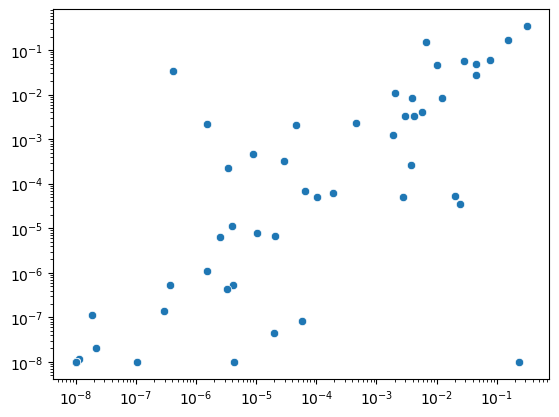

In [27]:
plt_ = sns.scatterplot(x=x_mean, y=y_mean)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [43]:
id_species_order

array([ 1,  8, 22, 23, 21, 51, 15, 45,  2, 55, 13, 17, 32, 25, 58, 11, 16,
       33, 60,  7, 54, 31, 42, 20, 56, 12, 18, 38, 19, 36, 39, 41, 24,  0,
       29, 59,  4, 48,  9, 52, 10, 53, 44, 34, 49,  5, 50, 37, 14,  6, 35,
        3, 28, 26, 61, 43, 40, 27, 57, 30, 47, 46, 62])